In [108]:
import sys
sys.version_info

sys.version_info(major=3, minor=9, micro=4, releaselevel='final', serial=0)

In [110]:
import scvi
import numpy as np
import pandas as pd
import os

import scanpy as sc
from anndata import AnnData, concat
from matplotlib.transforms import Bbox

# from scvi.model.utils import mde


from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
import seaborn as sns

from scipy import sparse
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx

from scipy.cluster import hierarchy

import re
import subprocess

import h5py

import itertools

from scnym.api import scnym_api

import pymn
import random 
from collections import Counter

In [109]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

pd.set_option('display.max_columns', 500)

In [111]:
def read_preprocess_data(input_h5):
    input_adata = sc.read_10x_h5(input_h5)
    input_adata.var_names_make_unique()
    sc.pp.normalize_total(input_adata, target_sum = 1e6)
    sc.pp.log1p(input_adata)
    sc.pp.highly_variable_genes(input_adata, n_top_genes=3000)
    sc.pp.pca(input_adata)
    sc.pp.neighbors(input_adata)
    sc.tl.umap(input_adata)
    return(input_adata)

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def set_max_score (rec_arr, max_score = 20):
    rec_mod = np.copy(rec_arr)
    for i in range(len(rec_arr)):
            for j in range(len(rec_mod[i])):
                    if rec_mod[i][j] > max_score:
                        rec_mod[i][j] = max_score
    return(rec_mod)


In [112]:
def write_rank_genes_groups_to_excel(adata, excel_path, groups = None):
    if groups is None:
        groups = adata.uns['rank_genes_groups']['names'].dtype.names
    
    writer = pd.ExcelWriter(excel_path, engine = 'xlsxwriter')
    
    for groupid in groups:
        group_df = sc.get.rank_genes_groups_df(adata, group=groupid)
        group_df.to_excel(writer, sheet_name = groupid)
    writer.save()
    # writer.close()


In [113]:
bm_dir = os.getcwd() + "/../SA_data"
bmSA_pilot_h5 = bm_dir + "/MR_30_10X_SA_PBS_BM_22112021_transcriptome" + "/filtered_feature_bc_matrix.h5"
bmSA_final_h5 = bm_dir + "/MR_33_10X_SA_PBS_BM_transcriptome" + "/filtered_feature_bc_matrix.h5"


In [6]:
# bmSA_pilot = read_preprocess_data(bmSA_pilot_h5)
# bmSA_final = read_preprocess_data(bmSA_final_h5)

In [7]:
dataset_fns = [
    bmSA_pilot_h5,
    bmSA_final_h5,
    'mouse_hsc_labeled.loom',
    'erythroid_and_monocyte_lineage_adata_no_gaps.loom',
    'processed_droplet_data_no_OBSM.loom'
]

dataset_names =[
    'SA_pilot',
    'SA_final',
    'Mouse_HSC',
    'Erythroid_monocyte',
    'annotated'
]
dataset_dict = dict(zip(dataset_names, dataset_fns))


In [41]:
raw_file_dir = "/users/anna.hakobyan/projects/bone_marrow_sc/mouse_bm_data/input_data/"
# datasets = []
for dataset in dataset_dict:
    try:
        print(dataset)
            
        if (dataset.startswith("SA")):
            adata = read_preprocess_data(dataset_dict[dataset])
        else:
            adata=sc.read_loom(raw_file_dir + dataset_dict[dataset])
            # adata.var_names = adata.var['var_names']
            
        adata.obs['study_id'] = dataset
        datasets.append(adata)
    except:
        print(dataset + ' Not Found')

SA_pilot


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/users/anna.hakobyan/.local/lib/python3.8/site-packages/numba/core/typed_passes.py:313: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.local/lib/python3.8/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


SA_final


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
combined_datasets = datasets[-1].concatenate(datasets[:-1])

NameError: name 'datasets' is not defined

In [7]:
combined_datasets.obs.cell_ontology_class.fillna('Unlabeled',inplace=True)
combined_datasets=combined_datasets[combined_datasets.obs.cell_ontology_class !='nan']

NameError: name 'combined_datasets' is not defined

In [44]:
combined_datasets.obs["cell_ontology_class"].value_counts()

Unlabeled                                      629446
granulocyte                                      1485
hematopoietic precursor cell                     1144
monocyte                                          787
naive B cell                                      692
late pro-B cell                                   571
pro-B cell                                        517
immature B cell                                   457
macrophage                                        395
proerythroblast                                   264
T cell                                            162
erythroblast                                      155
basophil                                           86
immature natural killer cell                       30
promonocyte                                         7
early pro-B cell                                    6
granulocytopoietic cell                             4
Fraction A pre-pro B cell                           4
B cell                      

In [45]:
cell_mapping = {"Unlabeled" : "Unlabeled",
                "granulocyte": "granulocyte",
                "hematopoietic precursor cell" : "hematopoietic precursor cell",
                "monocyte" : "monocyte",
                "naive B cell" : "B cell",
                "late pro-B cell" : "B cell",
                "pro-B cell" : "B cell",
                "immature B cell" : "B cell",
                "macrophage" : "macrophage",
                "proerythroblast" : "erythroblast",
                "T cell" : "T cell",
                "erythroblast" : "erythroblast",
                "basophil" : "basophil",
                "immature natural killer cell" : "NK cell",
                "promonocyte" : "monocyte",
                "early pro-B cell" : "B cell",
                "Fraction A pre-pro B cell" : "B cell",
                "granulocytopoietic cell" : "granulocyte",
                "B cell" : "B cell",
                "Slamf1-positive multipotent progenitor cell" : "Slamf1-positive multipotent progenitor cell"}

In [46]:
combined_datasets.obs["cell_ontology_condensed"] = combined_datasets.obs["cell_ontology_class"].map(cell_mapping)

Trying to set attribute `.obs` of view, copying.


In [47]:
%%time
scnym_api(adata=combined_datasets,
          task='train',
          groupby='cell_ontology_condensed',
          out_path='./scnym_output_condensed',
          config={
              'domain_groupby': 'study_id',
              'dan_use_conf_pseudolabels': False,
              'pseudolabel_min_confidence':.9
          })

CUDA compute device found.
629446 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (6771, 11951)
target   examples:  (629446, 11951)
X:  (6771, 11951)
y:  (6771,)
Not weighting classes and not balancing classes.
Found 2 unique domains.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
Saving best model weights

In [48]:
%%time
scnym_api(
    adata=combined_datasets,
    task='predict',
    key_added='scNym_condensed',
    trained_model='./scnym_output_condensed',
    out_path='./scnym_output_condensed',
    config='new_identity_discovery'
)


CUDA compute device found.


Finding cell types:   0%|                                            | 1/622 [00:00<01:29,  6.95it/s]

Loaded model predicting 10 classes from 11951 features
['B cell' 'NK cell' 'Slamf1-positive multipotent progenitor cell' 'T cell'
 'basophil' 'erythroblast' 'granulocyte' 'hematopoietic precursor cell'
 'macrophage' 'monocyte']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|██████████████████████████████████████████| 622/622 [01:24<00:00,  7.35it/s]


Extracting model embeddings...
CPU times: user 2min 49s, sys: 6.58 s, total: 2min 56s
Wall time: 2min 55s


### Writing the annotations

In [49]:
combined_datasets.obs.to_pickle("TM_combined_datasets_SA_ann_obs.plk")
combined_datasets.obs = combined_datasets.obs[["study_id", "cell_ontology_class"]]
combined_datasets.write(filename = "TM_combined_datasets_SA_ann.h5ad")

... storing 'study_id' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'feature_types-4' as categorical
... storing 'genome-4' as categorical


### Reading the annotations

In [8]:
### Directory TM_combined_datasets_SA_ann_obs
combined_datasets = sc.read_h5ad(filename = "TM_combined_datasets_SA_ann.h5ad")
obs_plk = pd.read_pickle("TM_combined_datasets_SA_ann_obs.plk")
combined_datasets.obs = obs_plk

In [7]:
# combined_datasets.X[:4, :4].todense()

In [8]:
# del(combined_datasets)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, 'B cell'),
  Text(2, 0, 'NK cell'),
  Text(3, 0, 'T cell'),
  Text(4, 0, 'basophil'),
  Text(5, 0, 'erythroblast'),
  Text(6, 0, 'granulocyte'),
  Text(7, 0, 'hematopoietic precursor cell'),
  Text(8, 0, 'macrophage'),
  Text(9, 0, 'monocyte')])

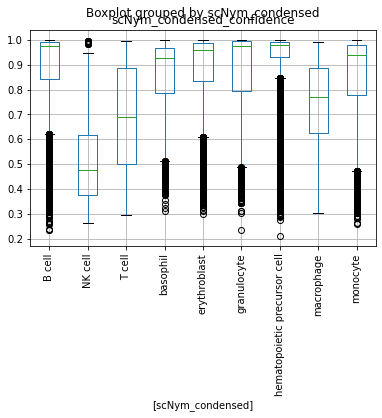

In [9]:
combined_datasets.obs.boxplot(column = ["scNym_condensed_confidence"], by = ["scNym_condensed"])
plt.xticks(rotation=90)

In [10]:
combined_datasets.obs["scNym_condensed"].value_counts()

hematopoietic precursor cell    281342
B cell                          181750
erythroblast                     82156
monocyte                         44938
granulocyte                      32772
macrophage                        8414
basophil                          3401
T cell                            1048
NK cell                            396
Name: scNym_condensed, dtype: int64

### Comparing with available annotations

In [28]:
hvg = sc.read("../output/hvg_integrated.h5ad")
SA_exps = combined_datasets[combined_datasets.obs["study_id"].isin(['SA_pilot', 'SA_final'])]

In [29]:
hvg.shape

(5517, 5182)

In [30]:
hvg_cells = hvg.obs_names
SA_exp_names = SA_exps.obs_names

SA_hvg_cells = [x for x in SA_exp_names if x[:-2] in hvg_cells]


SA_cellname_counts = Counter([x[:-2] for x in SA_hvg_cells])
SA_unique_names = [x for x in SA_hvg_cells if SA_cellname_counts[x[:-2]] == 1]


SA_exps_subset = SA_exps[SA_unique_names]

SA_exps_subset.obs_names = [x[:-2] for x in SA_exps_subset.obs_names]

hvg_subset = hvg[SA_exps_subset.obs_names]

hvg_subset.obs["scNym_condensed"] = SA_exps_subset.obs["scNym_condensed"]
hvg_subset.obs["scNym_condensed_confidence"] = SA_exps_subset.obs["scNym_condensed_confidence"]

Trying to set attribute `.obs` of view, copying.


In [9]:
SA_exps_subset.obs_names

Index(['AAACGAACACAATGCT-1', 'AAACGCTTCTCCTGTG-1', 'AAAGAACCACTACACA-1',
       'AAAGAACCAGCCGTCA-1', 'AAAGGATGTAGCTAAA-1', 'AAAGTGAAGAAACTGT-1',
       'AACAAAGGTGTTGCCG-1', 'AACAAAGTCACAGTGT-1', 'AACAACCCAGAGAATT-1',
       'AACAACCCAGATCCAT-1',
       ...
       'TTTGATCTCTCGGTCT-1', 'TTTGGAGCACGGTGCT-1', 'TTTGGAGCACTCCACT-1',
       'TTTGGTTCAATCAAGA-1', 'TTTGGTTCAGAGACTG-1', 'TTTGGTTCAGGTGTGA-1',
       'TTTGGTTTCAAGTAAG-1', 'TTTGTTGAGCACGATG-1', 'TTTGTTGGTCCACTCT-1',
       'TTTGTTGGTCCTGGTG-1'],
      dtype='object', length=5514)

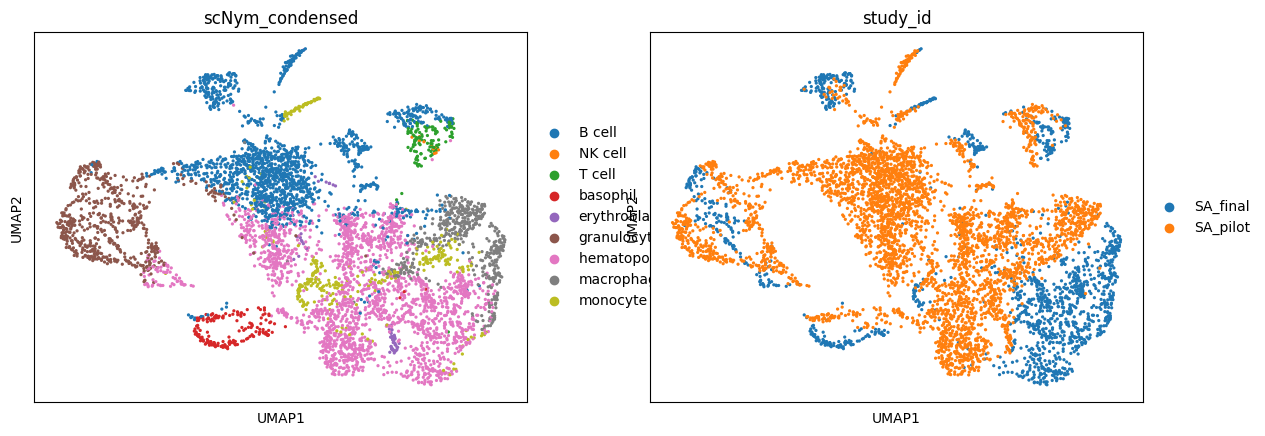

In [33]:
sc.pl.umap(SA_exps_subset,
    color= ['scNym_condensed', 'study_id']
          )

In [14]:
SA_exps.obs['scNym_condensed'].value_counts()

B cell                          5389
hematopoietic precursor cell    4071
granulocyte                     1046
macrophage                       563
monocyte                         538
T cell                           344
basophil                         224
erythroblast                     116
NK cell                           18
Name: scNym_condensed, dtype: int64

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, 'B cell'),
  Text(2, 0, 'NK cell'),
  Text(3, 0, 'T cell'),
  Text(4, 0, 'basophil'),
  Text(5, 0, 'erythroblast'),
  Text(6, 0, 'granulocyte'),
  Text(7, 0, 'hematopoietic precursor cell'),
  Text(8, 0, 'macrophage'),
  Text(9, 0, 'monocyte')])

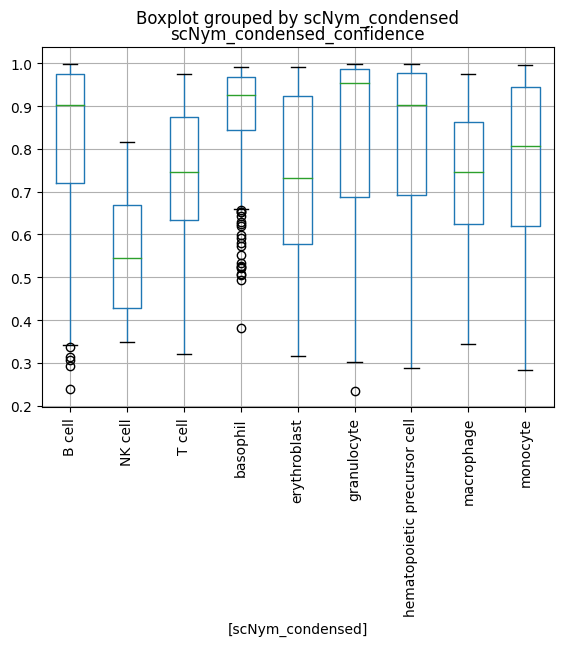

In [15]:
SA_exps.obs.boxplot(column = ["scNym_condensed_confidence"], by = ["scNym_condensed"])
plt.xticks(rotation=90)

In [16]:
hsc_confidence = SA_exps.obs[SA_exps.obs["scNym_condensed"] == "hematopoietic precursor cell"]["scNym_condensed_confidence"]

In [17]:
len(hsc_confidence)

4071

In [29]:
hvg_subset.obs["condition"] = [x[4:-1] for x in hvg_subset.obs["HTO_classification"]]

In [19]:
hvg_subset.obs["scNym_condensed"]

AAACGAACACAATGCT-1    hematopoietic precursor cell
AAACGCTTCTCCTGTG-1                     granulocyte
AAAGAACCACTACACA-1                          B cell
AAAGAACCAGCCGTCA-1                          B cell
AAAGGATGTAGCTAAA-1                        basophil
                                  ...             
TTTGGTTCAGGTGTGA-1    hematopoietic precursor cell
TTTGGTTTCAAGTAAG-1    hematopoietic precursor cell
TTTGTTGAGCACGATG-1                      macrophage
TTTGTTGGTCCACTCT-1                          B cell
TTTGTTGGTCCTGGTG-1                      macrophage
Name: scNym_condensed, Length: 5514, dtype: object

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, 'B cell'),
  Text(2, 0, 'NK cell'),
  Text(3, 0, 'T cell'),
  Text(4, 0, 'basophil'),
  Text(5, 0, 'erythroblast'),
  Text(6, 0, 'granulocyte'),
  Text(7, 0, 'hematopoietic precursor cell'),
  Text(8, 0, 'macrophage'),
  Text(9, 0, 'monocyte')])

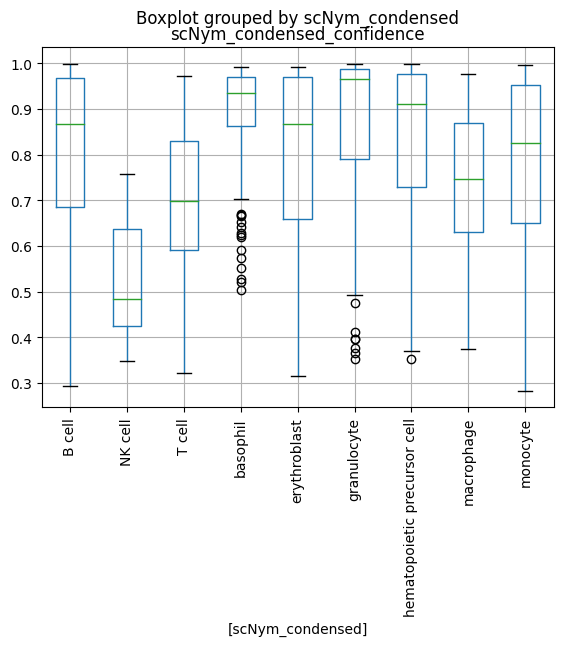

In [20]:
hvg_subset.obs.boxplot(column = ["scNym_condensed_confidence"], by = ["scNym_condensed"])
plt.xticks(rotation=90)

In [21]:
sc.tl.umap(hvg_subset)

In [22]:
os.getcwd()

'/users/anna.hakobyan/projects/bone_marrow_sc/notebooks'

... storing 'scNym_condensed' as categorical
... storing 'condition' as categorical


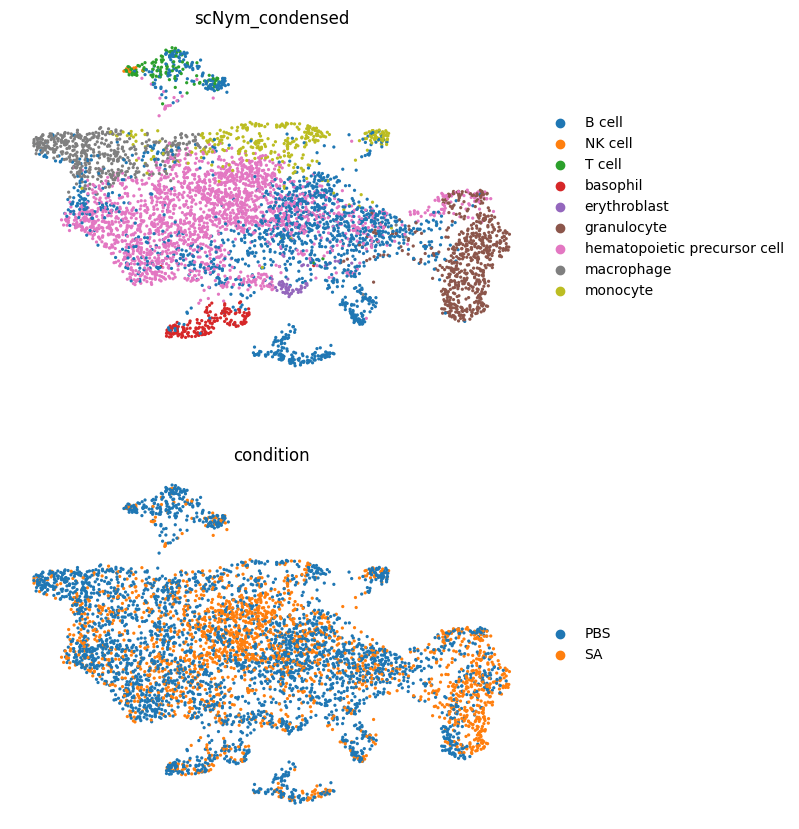

In [23]:
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=['scNym_condensed', 'condition'],
    frameon=False,
    ncols=1,
    save = "scNym_umap.pdf"
)

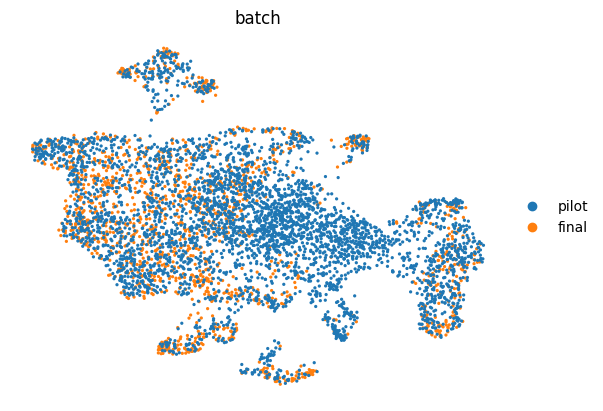

In [34]:
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=['batch'],
    frameon=False,
    ncols=1,
    save = "batch_all_cells_integrated.pdf"
)

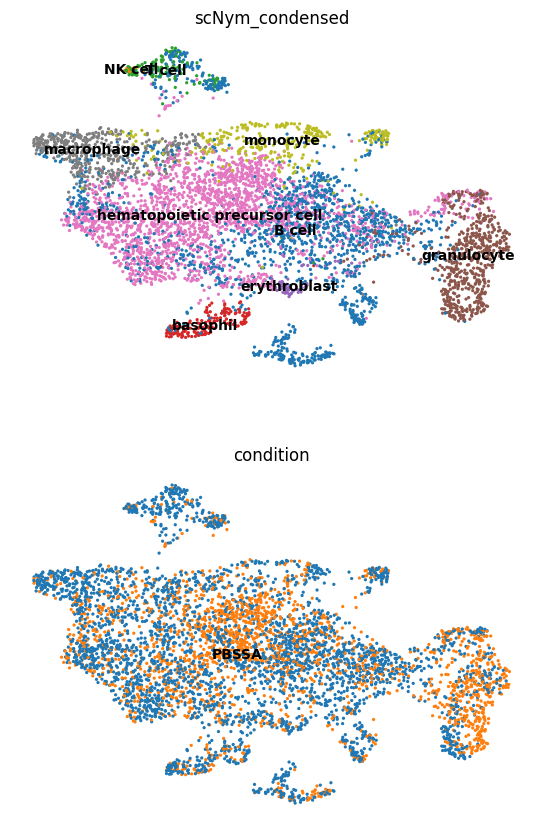

In [24]:
sc.pl.embedding(
    hvg_subset,
    basis="umap",
    color=['scNym_condensed', 'condition'],
    frameon=False,
    ncols=1,
    legend_loc='on data',
    save = "scNym_umap_labeled.pdf"
)

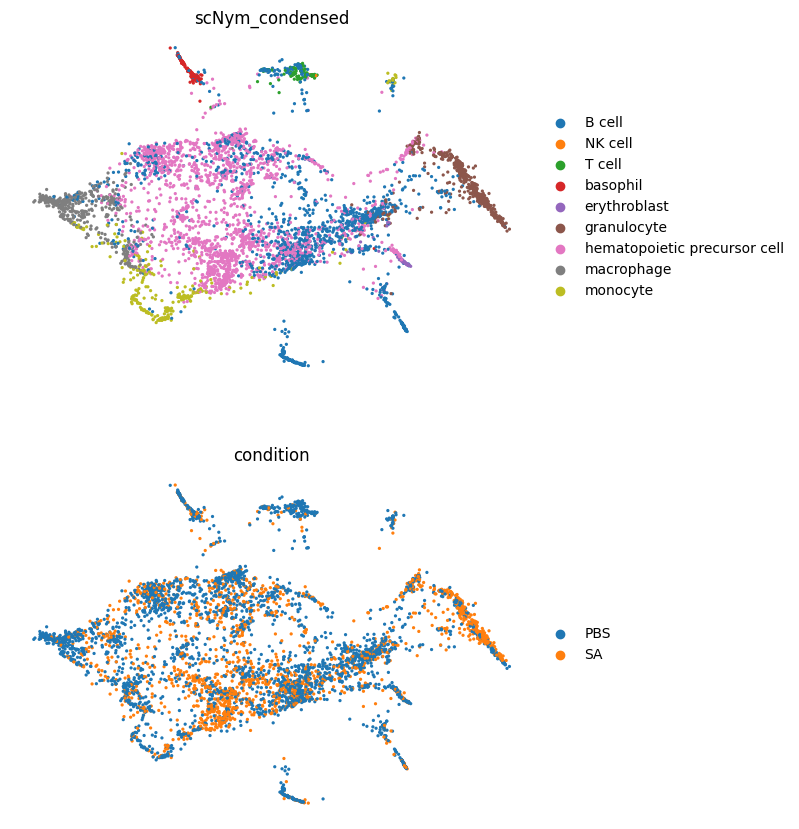

In [25]:
sc.pl.embedding(
    hvg_subset,
    basis="X_mde",
    color=['scNym_condensed', 'condition'],
    frameon=False,
    ncols=1,
    save = "scNym_mde.pdf"
)

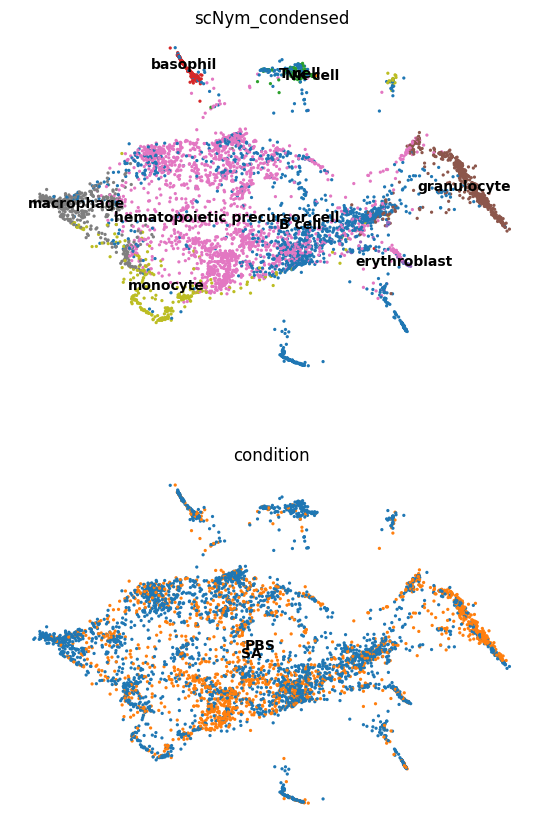

In [26]:
sc.pl.embedding(
    hvg_subset,
    basis="X_mde",
    color=['scNym_condensed', 'condition'],
    frameon=False,
    ncols=1,
    legend_loc='on data',
    save = "scNym_mde_labeled.pdf"
)


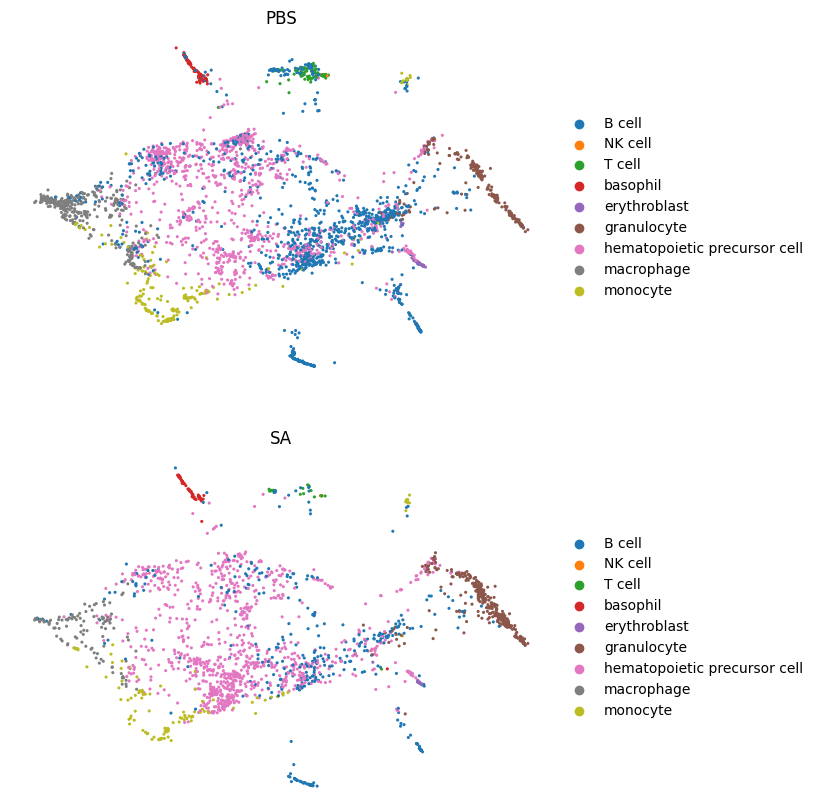

In [27]:
fig, (ax1, ax2) =  plt.subplots(2, 1, figsize=(7, 10))
p1 = sc.pl.embedding(
    hvg_subset[hvg_subset.obs["condition"] == "PBS"],
    basis="X_mde",
    title = "PBS",
    color='scNym_condensed',
    size = 20,
    frameon=False,
    ncols=1,
    show = False,
    ax = ax1
)
p2 = sc.pl.embedding(
    hvg_subset[hvg_subset.obs["condition"] == "SA"],
    basis="X_mde",
    title = "SA",
    size = 20,
    color='scNym_condensed',
    frameon=False,
    ncols=1,
    show = False,
    ax = ax2
)

# extent = full_extent(ax2).transformed(fig.dpi_scale_trans.inverted())
fig.savefig("figures/facet_SA_mde_scNym.pdf", bbox_inches = "tight")

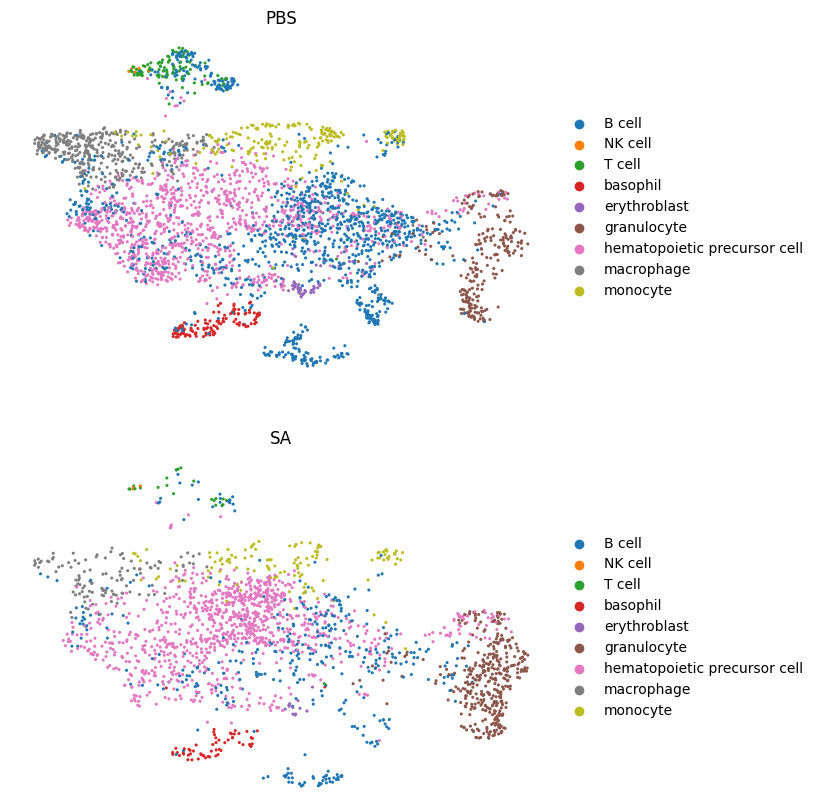

In [28]:
fig, (ax1, ax2) =  plt.subplots(2, 1, figsize=(7, 10))
p1 = sc.pl.embedding(
    hvg_subset[hvg_subset.obs["condition"] == "PBS"],
    basis="umap",
    title = "PBS",
    color='scNym_condensed',
    size = 20,
    frameon=False,
    ncols=1,
    show = False,
    ax = ax1
)
p2 = sc.pl.embedding(
    hvg_subset[hvg_subset.obs["condition"] == "SA"],
    basis="umap",
    title = "SA",
    size = 20,
    color='scNym_condensed',
    frameon=False,
    ncols=1,
    show = False,
    ax = ax2
)

# extent = full_extent(ax2).transformed(fig.dpi_scale_trans.inverted())
fig.savefig("figures/facet_SA_umap_scNym.pdf", bbox_inches = "tight")

### Rank genes groups

In [10]:
# sc.pp.normalize_total(hvg_subset, target_sum=1e6)
sc.pp.log1p(hvg_subset)

In [72]:
hvg_subset.X.toarray().max(axis = 0).max()

13.658878

In [74]:
len(hvg_subset)

5514

In [75]:
hvg_subset.obs['scNym_condensed'].value_counts()

hematopoietic precursor cell    2129
B cell                          1609
granulocyte                      595
macrophage                       480
monocyte                         339
basophil                         171
T cell                           124
erythroblast                      57
NK cell                           10
Name: scNym_condensed, dtype: int64

In [76]:
sc.tl.rank_genes_groups(hvg_subset, 'scNym_condensed', method='wilcoxon', use_raw = False)

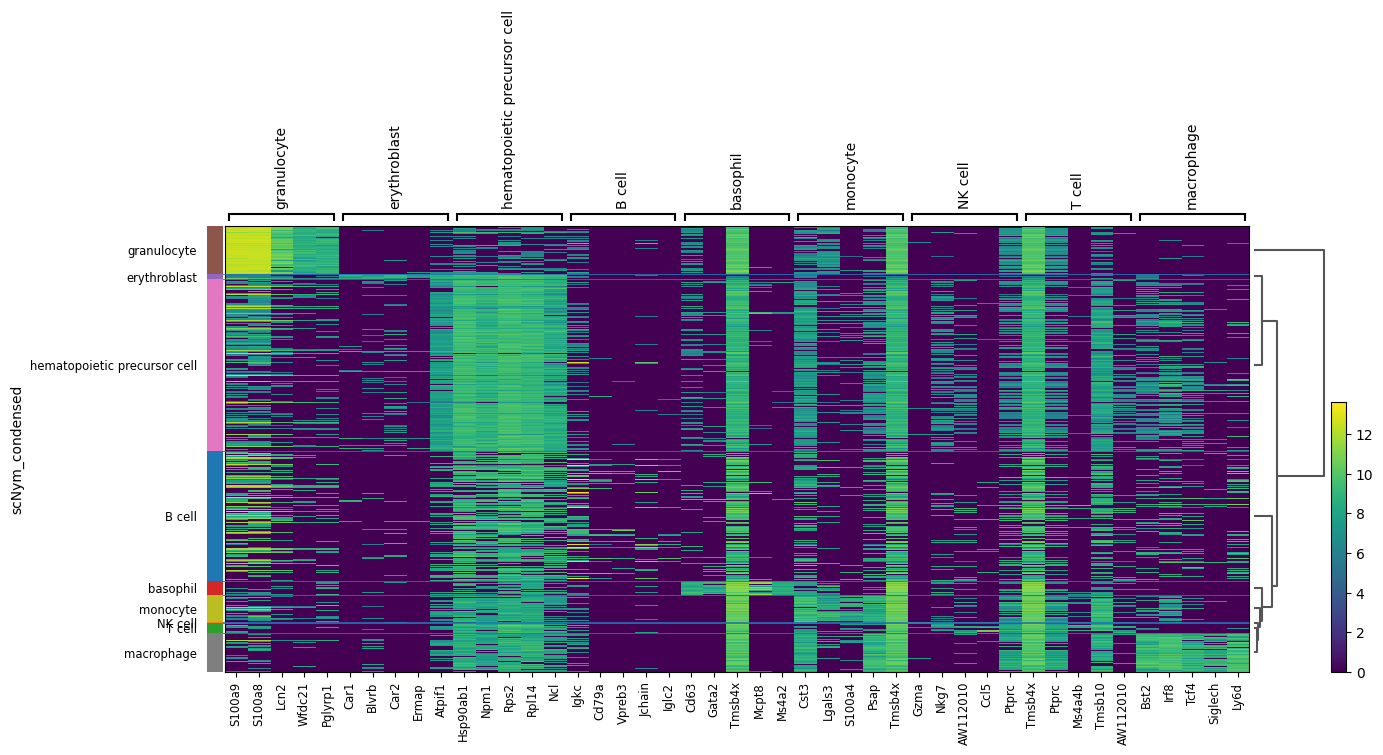

In [77]:
sc.pl.rank_genes_groups_heatmap(hvg_subset, n_genes = 5, use_raw = False, save = "scNym_annotation_all_classes_no_genenames.pdf")

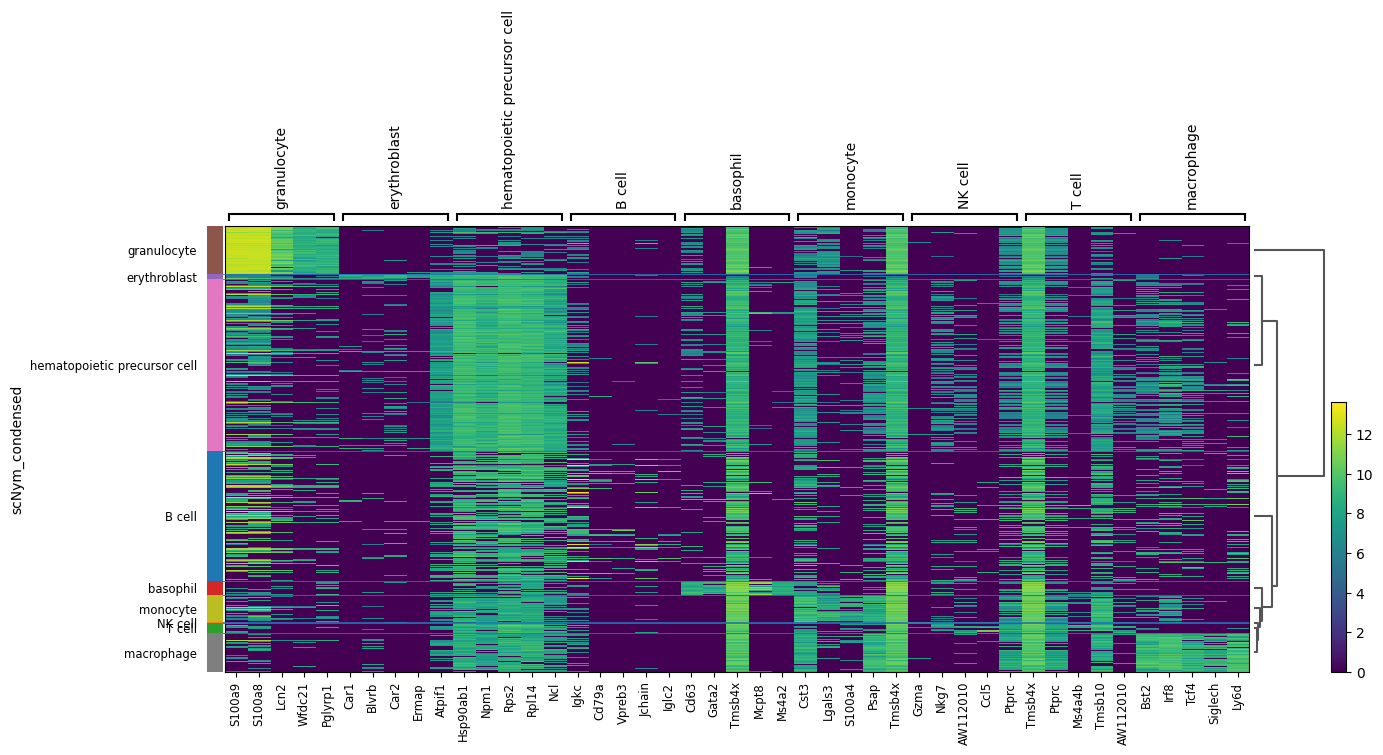

In [78]:
sc.pl.rank_genes_groups_heatmap(hvg_subset, n_genes = 5, use_raw = False, show_gene_labels=True,save = "scNym_annotation_all_classes_with_genenames.pdf")

In [79]:
# hvg_subset.uns['rank_genes_groups']

{'params': {'groupby': 'scNym_condensed',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Igkc', 'Gzma', 'Tmsb4x', 'Cd63', 'Car1', 'S100a9', 'Hsp90ab1', 'Bst2', 'Cst3'),
            ('Cd79a', 'Nkg7', 'Ptprc', 'Gata2', 'Blvrb', 'S100a8', 'Npm1', 'Irf8', 'Lgals3'),
            ('Vpreb3', 'AW112010', 'Ms4a4b', 'Tmsb4x', 'Car2', 'Lcn2', 'Rps2', 'Tcf4', 'S100a4'),
            ...,
            ('Mrpl33', 'Ifitm2', 'Ifitm2', 'Hsp90ab1', 'Plac8', 'Rpl14', 'S100a6', 'Ifitm1', 'Npm1'),
            ('S100a11', 'Plac8', 'Gpx1', 'Rps2', 'Arhgdib', 'Ptma', 'Cd52', 'Ifitm3', 'Myb'),
            ('Alox5ap', 'Gpx1', 'Plac8', 'H2afy', 'Tmsb4x', 'Rpl41', 'Tmsb4x', 'Ifitm2', 'Ncl')],
           dtype=[('B cell', 'O'), ('NK cell', 'O'), ('T cell', 'O'), ('basophil', 'O'), ('erythroblast', 'O'), ('granulocyte', 'O'), ('hematopoietic precursor cell', 'O'), ('macrophage', 'O'), ('monocyte', 'O')]),
 'scores': re

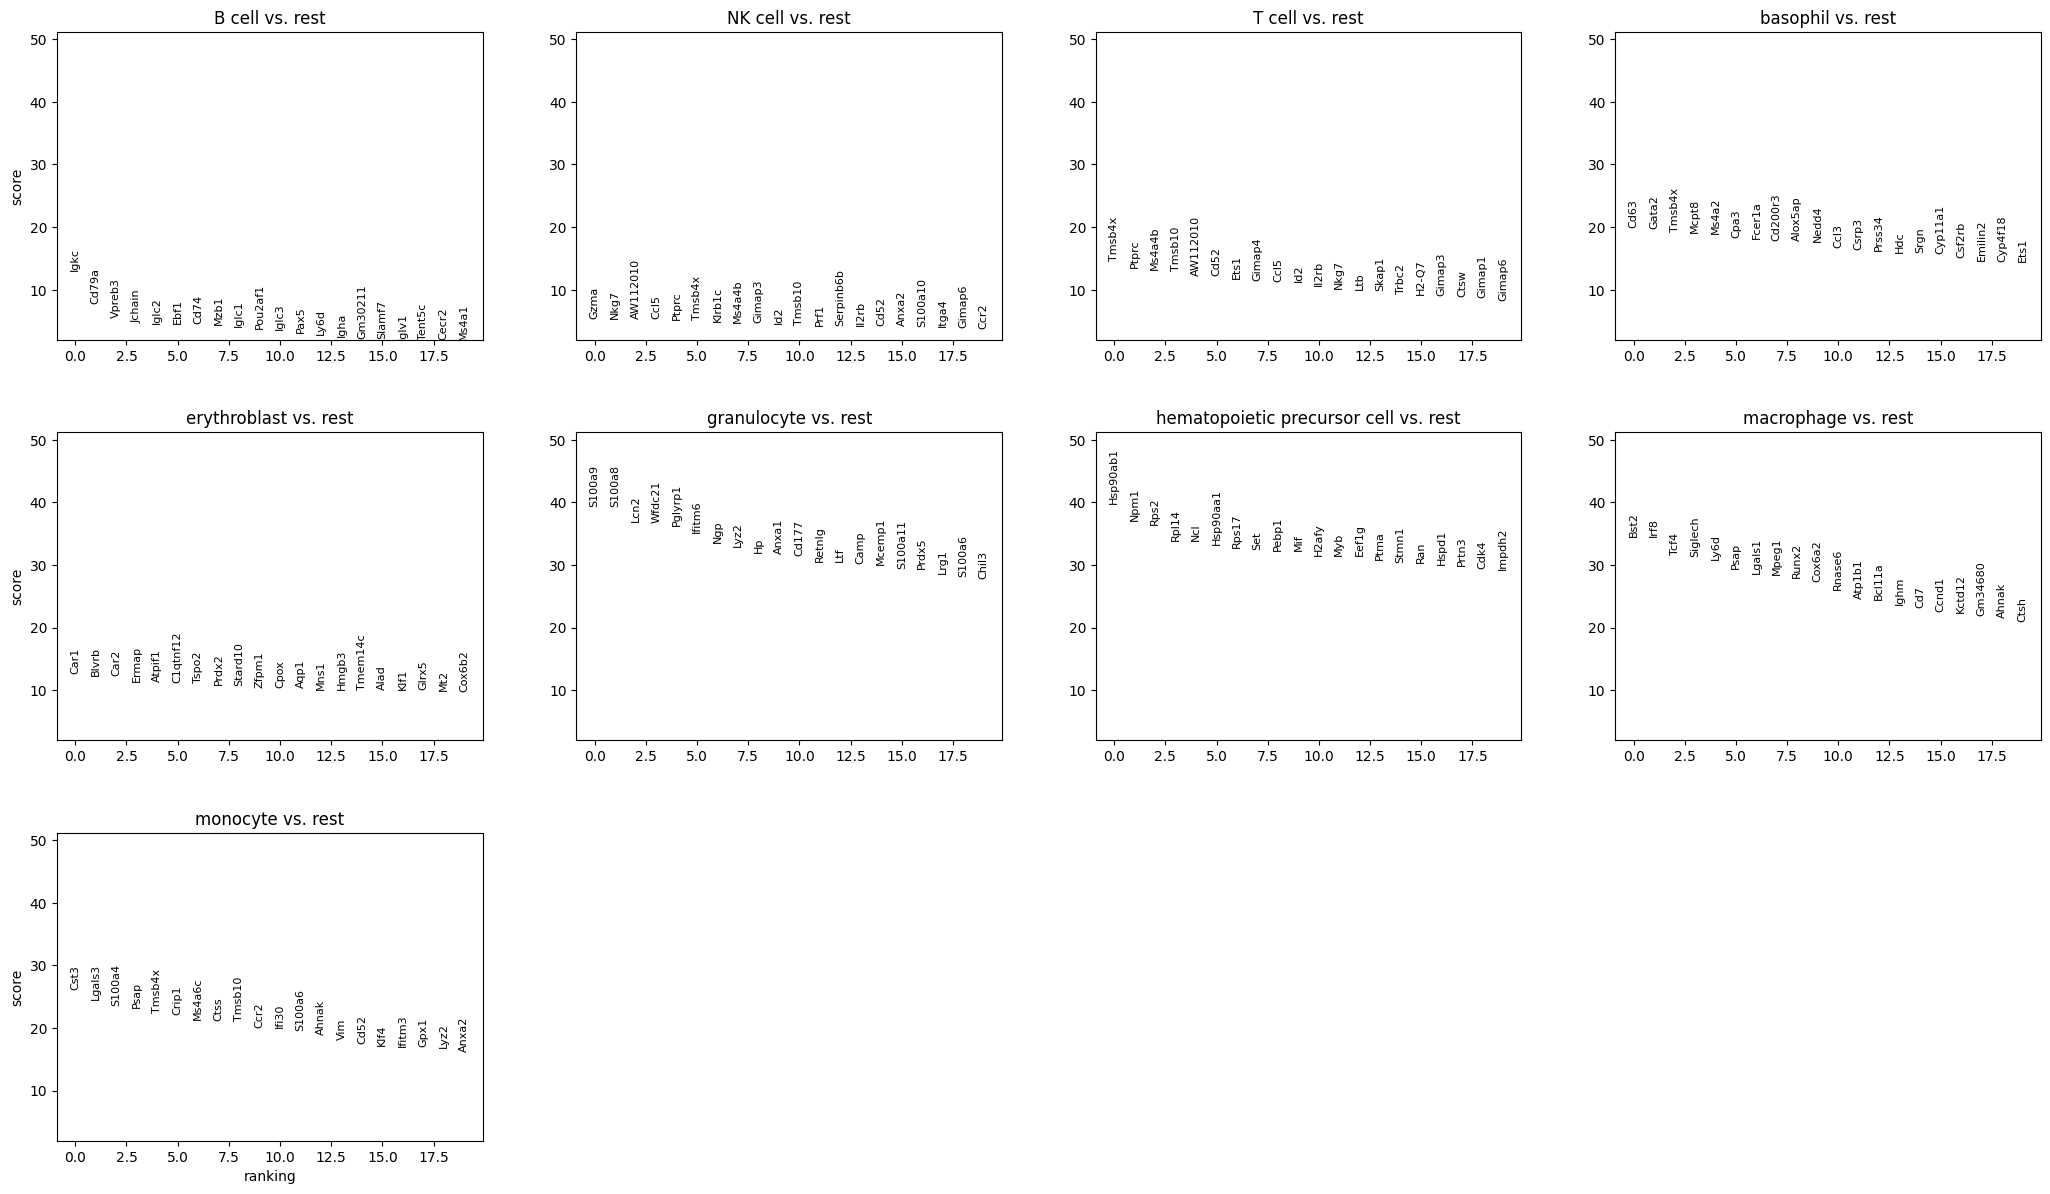

In [80]:
# to visualize the results
sc.pl.rank_genes_groups(hvg_subset, ncol = 3, save = "scNym_all_celltype_diff_exps_genes.pdf")

### Checking the UMAP for batches with log transform

In [11]:
sc.tl.pca(hvg_subset)
sc.pp.neighbors(hvg_subset)
sc.tl.umap(hvg_subset, random_state=1)

... storing 'scNym_condensed' as categorical


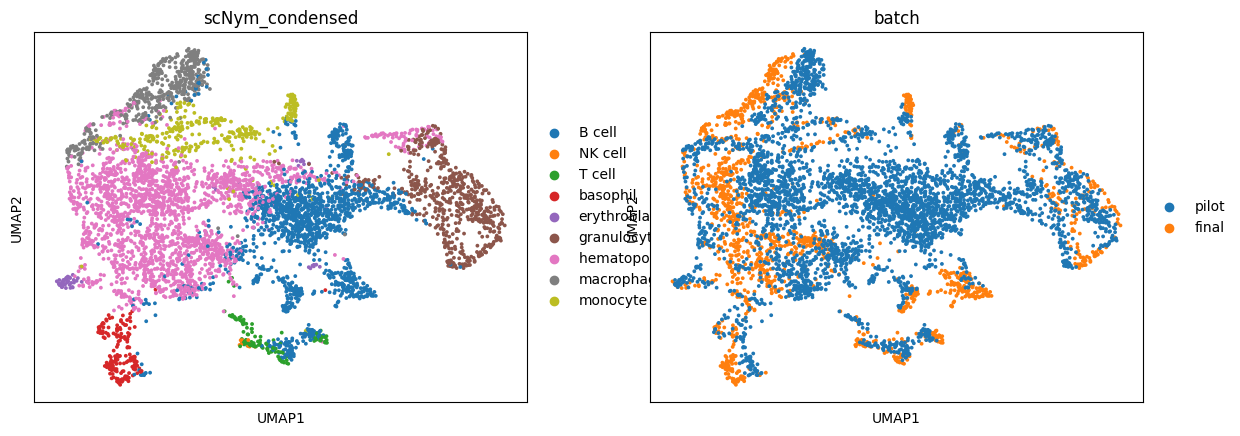

In [12]:
# sc.set_figure_params(figsize = (5,4))
sc.pl.umap(hvg_subset, color=[ 'scNym_condensed', 'batch' ], size = 30
           # ,save = "all_HSC_umap.pdf"
          )

### Writing DEG genes to an excel file

In [82]:
sc.tl.rank_genes_groups(hvg_subset, 'scNym_condensed', method='wilcoxon', use_raw = False)

In [83]:
write_rank_genes_groups_to_excel(adata = hvg_subset, excel_path = "all_BM_cells_scNym_DEGs.xlsx")

### Annotation of hematopoietic precursor cells based on facs data 

In [85]:
SA_HPC = SA_exps[ SA_exps.obs["scNym_condensed"] == "hematopoietic precursor cell" ]

In [86]:
SA_HPC.obs_names

Index(['AAACGAACACAATGCT-1-0', 'AAAGTGAAGAAACTGT-1-0', 'AACAACCCAGAGAATT-1-0',
       'AACAACCCAGATCCAT-1-0', 'AACAACCCATATACCG-1-0', 'AACACACCATAGTCGT-1-0',
       'AACAGGGGTGAACCGA-1-0', 'AACAGGGTCCATACTT-1-0', 'AACCAACTCCTTGACC-1-0',
       'AACCACAAGAGCCCAA-1-0',
       ...
       'TTTGATCCACTCTGCT-1-4', 'TTTGATCCATTACGGT-1-4', 'TTTGATCGTCAAACGG-1-4',
       'TTTGATCGTTCAAACC-1-4', 'TTTGGAGCACTCCACT-1-4', 'TTTGGAGGTACTGCCG-1-4',
       'TTTGGTTCAATCAAGA-1-4', 'TTTGGTTCAGGTGTGA-1-4', 'TTTGGTTTCAAGTAAG-1-4',
       'TTTGTTGTCGACCAAT-1-4'],
      dtype='object', length=4071)

In [87]:
SA_HPC.shape

(4071, 11951)

In [91]:
combined_HSC = datasets[2].concatenate(SA_HPC)

In [92]:
combined_HSC.obs.FACS_labels.fillna('Unlabeled',inplace=True)
combined_HSC=combined_HSC[combined_HSC.obs.FACS_labels != 'nan']

In [93]:
combined_HSC.obs.FACS_labels

b'AAACCTGAGACAAAGG-1_SIGAB1'-0        STHSC
b'AAACCTGAGATGGGTC-1_SIGAB1'-0         MPP4
b'AAACCTGAGGCTAGGT-1_SIGAB1'-0        STHSC
b'AAACCTGCAATAGCGG-1_SIGAB1'-0        STHSC
b'AAACCTGCAATGACCT-1_SIGAB1'-0         MPP3
                                    ...    
TTTGGAGGTACTGCCG-1-4-1            Unlabeled
TTTGGTTCAATCAAGA-1-4-1            Unlabeled
TTTGGTTCAGGTGTGA-1-4-1            Unlabeled
TTTGGTTTCAAGTAAG-1-4-1            Unlabeled
TTTGTTGTCGACCAAT-1-4-1            Unlabeled
Name: FACS_labels, Length: 126530, dtype: object

### Writing cominbed_HSC

In [54]:
# combined_HSC.obs.to_pickle("TM_combined_HSC_SA_obs.plk")
# combined_HSC.obs = combined_HSC.obs[["study_id", "cell_ontology_class"]]
# combined_HSC.write(filename = "TM_combined_HSC_SA.h5ad")
# combined_HSC.write_loom(filename = "TM_combined_HSC_SA.loom")


### Reading combined_HSC

In [7]:
# ### Directory TM_combined_HSC_SA_ann_obs
# combined_HSC = sc.read_h5ad(filename = "TM_combined_HSC_SA.h5ad")
# obs_plk = pd.read_pickle("TM_combined_HSC_SA_obs.plk")
# combined_HSC.obs = obs_plk
# combined_HSC = sc.read_loom(filename = "TM_combined_HSC_SA.loom")


In [94]:
os.getcwd()

'/users/anna.hakobyan/projects/bone_marrow_sc/notebooks'

In [95]:
%%time
scnym_api(adata=combined_HSC,
          task='train',
          groupby='FACS_labels',
          out_path='./scnym_output_HPC',
          config={
              'domain_groupby': 'study_id',
              'dan_use_conf_pseudolabels': False,
              'pseudolabel_min_confidence':.9
          })

CUDA compute device found.
4071 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (122459, 11951)
target   examples:  (4071, 11951)
X:  (122459, 11951)
y:  (122459,)
Not weighting classes and not balancing classes.
Found 2 unique domains.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Saving best model weights...______________|
Saved best weights.
Trainer has a `dan_criterion`.
Saving DAN weights...
>>>>> 61/99|------------------____________|
Early stopping at epoch 61
>>>>>
Training complete.

Evaluating model.


Trying to set attribute `.uns` of view, copying.


EVAL LOSS:  0.11502898531034589
EVAL ACC :  0.9821982688224726
Predictions | Labels
[[4 4]
 [3 3]
 [4 4]
 [4 4]
 [3 3]
 [4 4]
 [2 2]
 [4 4]
 [4 4]
 [3 3]
 [4 4]
 [2 2]
 [3 3]
 [4 4]
 [3 3]]
CPU times: user 39min 1s, sys: 1min 15s, total: 40min 17s
Wall time: 35min 14s


In [96]:
%%time
scnym_api(
    adata=combined_HSC,
    task='predict',
    key_added='scNym_HPC',
    trained_model='./scnym_output_HPC',
    out_path='./scnym_output_HPC',
    config='new_identity_discovery'
)

CUDA compute device found.


Finding cell types:   1%|▎                                           | 1/124 [00:00<00:19,  6.17it/s]

Loaded model predicting 6 classes from 11951 features
['LTHSC' 'MPP2' 'MPP3' 'MPP4' 'STHSC' 'Unknown']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|██████████████████████████████████████████| 124/124 [00:16<00:00,  7.31it/s]


Extracting model embeddings...
CPU times: user 38 s, sys: 1.64 s, total: 39.7 s
Wall time: 39.5 s


### Writing scNym annotated loom file for HSCs

In [ ]:
combined_HSC.write_loom(filename = "TM_combined_HSC_SA_ann.loom", write_obsm_varm=True)

### Reading scNym annotated loom file for HSCs

In [11]:
os.getcwd()

'/users/anna.hakobyan/projects/bone_marrow_sc/notebooks'

In [14]:
combined_HSC = sc.read_loom(filename = "TM_combined_HSC_SA_ann.loom")

In [15]:
annotated_SA_HSC = combined_HSC[ combined_HSC.obs["study_id"].isin(["SA_final", "SA_pilot"])]

In [16]:
annotated_SA_HSC.obs_names

Index(['AAACGAACACAATGCT-1-0-1', 'AAAGTGAAGAAACTGT-1-0-1',
       'AACAACCCAGAGAATT-1-0-1', 'AACAACCCAGATCCAT-1-0-1',
       'AACAACCCATATACCG-1-0-1', 'AACACACCATAGTCGT-1-0-1',
       'AACAGGGGTGAACCGA-1-0-1', 'AACAGGGTCCATACTT-1-0-1',
       'AACCAACTCCTTGACC-1-0-1', 'AACCACAAGAGCCCAA-1-0-1',
       ...
       'TTTGATCCACTCTGCT-1-4-1', 'TTTGATCCATTACGGT-1-4-1',
       'TTTGATCGTCAAACGG-1-4-1', 'TTTGATCGTTCAAACC-1-4-1',
       'TTTGGAGCACTCCACT-1-4-1', 'TTTGGAGGTACTGCCG-1-4-1',
       'TTTGGTTCAATCAAGA-1-4-1', 'TTTGGTTCAGGTGTGA-1-4-1',
       'TTTGGTTTCAAGTAAG-1-4-1', 'TTTGTTGTCGACCAAT-1-4-1'],
      dtype='object', length=4071)

In [17]:
hvg_subset.obs_names

Index(['AAACGAACACAATGCT-1', 'AAACGCTTCTCCTGTG-1', 'AAAGAACCACTACACA-1',
       'AAAGAACCAGCCGTCA-1', 'AAAGGATGTAGCTAAA-1', 'AAAGTGAAGAAACTGT-1',
       'AACAAAGGTGTTGCCG-1', 'AACAAAGTCACAGTGT-1', 'AACAACCCAGAGAATT-1',
       'AACAACCCAGATCCAT-1',
       ...
       'TTTGATCTCTCGGTCT-1', 'TTTGGAGCACGGTGCT-1', 'TTTGGAGCACTCCACT-1',
       'TTTGGTTCAATCAAGA-1', 'TTTGGTTCAGAGACTG-1', 'TTTGGTTCAGGTGTGA-1',
       'TTTGGTTTCAAGTAAG-1', 'TTTGTTGAGCACGATG-1', 'TTTGTTGGTCCACTCT-1',
       'TTTGTTGGTCCTGGTG-1'],
      dtype='object', length=5514)

In [18]:
ann_counts = Counter([x[:-4] for x in annotated_SA_HSC.obs_names])
unique_names = [x for x in annotated_SA_HSC.obs_names if ann_counts[x[:-4]] == 1]
annotated_SA_HSC = annotated_SA_HSC[unique_names]
annotated_SA_HSC.obs_names = [x[:-4] for x in annotated_SA_HSC.obs_names]

In [19]:
annotated_SA_HSC.shape

(4069, 11951)

In [20]:
common_cells = annotated_SA_HSC.obs_names.intersection(hvg_subset.obs_names)

In [21]:
len(set(common_cells))

2129

In [22]:
hvg_subset_HSC = hvg_subset[common_cells]

In [23]:
annotated_SA_HSC_hvg = annotated_SA_HSC[common_cells]

In [24]:
hvg_subset_HSC.obs["HSC_annotation"] = annotated_SA_HSC_hvg.obs["scNym_HPC"]

Trying to set attribute `.obs` of view, copying.


In [25]:
hvg_subset_HSC.obs["HSC_annotation"].value_counts()

STHSC      868
MPP4       696
MPP3       535
LTHSC       22
MPP2         7
Unknown      1
Name: HSC_annotation, dtype: int64

/users/anna.hakobyan/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'scNym_condensed' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'HSC_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'scNym_condensed' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'HSC_annotation' as categorical


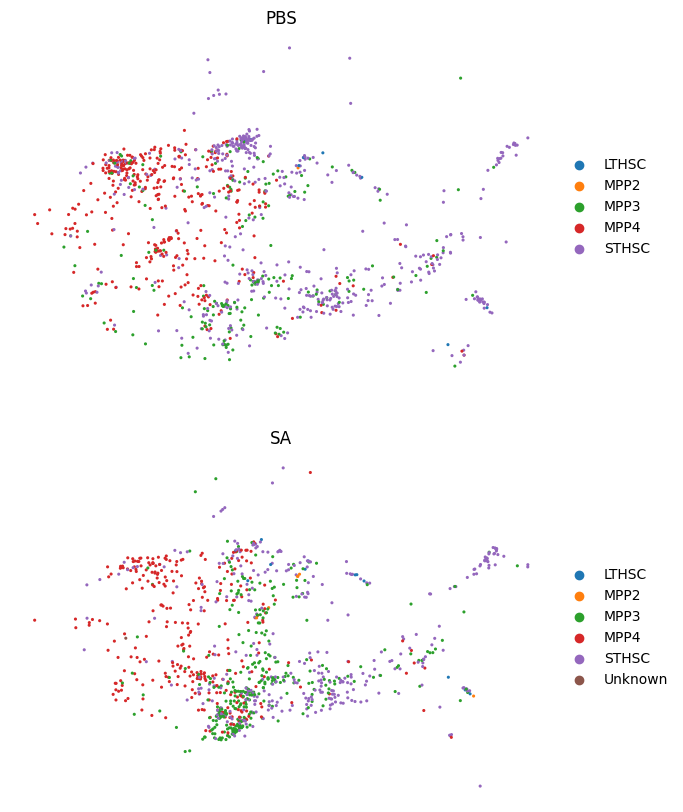

In [57]:
fig, (ax1, ax2) =  plt.subplots(2, 1, figsize=(7, 10))
p1 = sc.pl.embedding(
    hvg_subset_HSC[hvg_subset_HSC.obs["condition"] == "PBS"],
    basis="X_mde",
    title = "PBS",
    color='HSC_annotation',
    size = 20,
    frameon=False,
    ncols=1,
    show = False,
    ax = ax1
)
p2 = sc.pl.embedding(
    hvg_subset_HSC[hvg_subset_HSC.obs["condition"] == "SA"],
    basis="X_mde",
    title = "SA",
    size = 20,
    color='HSC_annotation',
    frameon=False,
    ncols=1,
    show = False,
    ax = ax2
)

# extent = full_extent(ax2).transformed(fig.dpi_scale_trans.inverted())
fig.savefig("figures/facet_SA_mde_HSC_FACS_annotation.pdf", bbox_inches = "tight")

### Writing hvg_subset_HSC

In [43]:
hvg_subset_HSC.obs.to_pickle("hvg_lineage_annotation.plk")
hvg_subset_HSC.obs = hvg_subset_HSC.obs[["HSC_annotation"]]
hvg_subset_HSC.write(filename = "hvg_lineage_annotation.h5ad")

### Reading hvg_subset_HSC

In [114]:
### Directory TM_hvg_subset_HSC_SA_ann_obs
hvg_subset_HSC = sc.read_h5ad(filename = "hvg_lineage_annotation.h5ad")
obs_plk = pd.read_pickle("hvg_lineage_annotation.plk")
hvg_subset_HSC.obs = obs_plk

In [115]:
hvg_subset_HSC.raw


In [116]:
random.seed(1342465)
sc.tl.pca(hvg_subset_HSC)
sc.pp.neighbors(hvg_subset_HSC)
sc.tl.umap(hvg_subset_HSC, random_state=10)
sc.tl.leiden(hvg_subset_HSC, resolution=0.48, n_iterations=100)

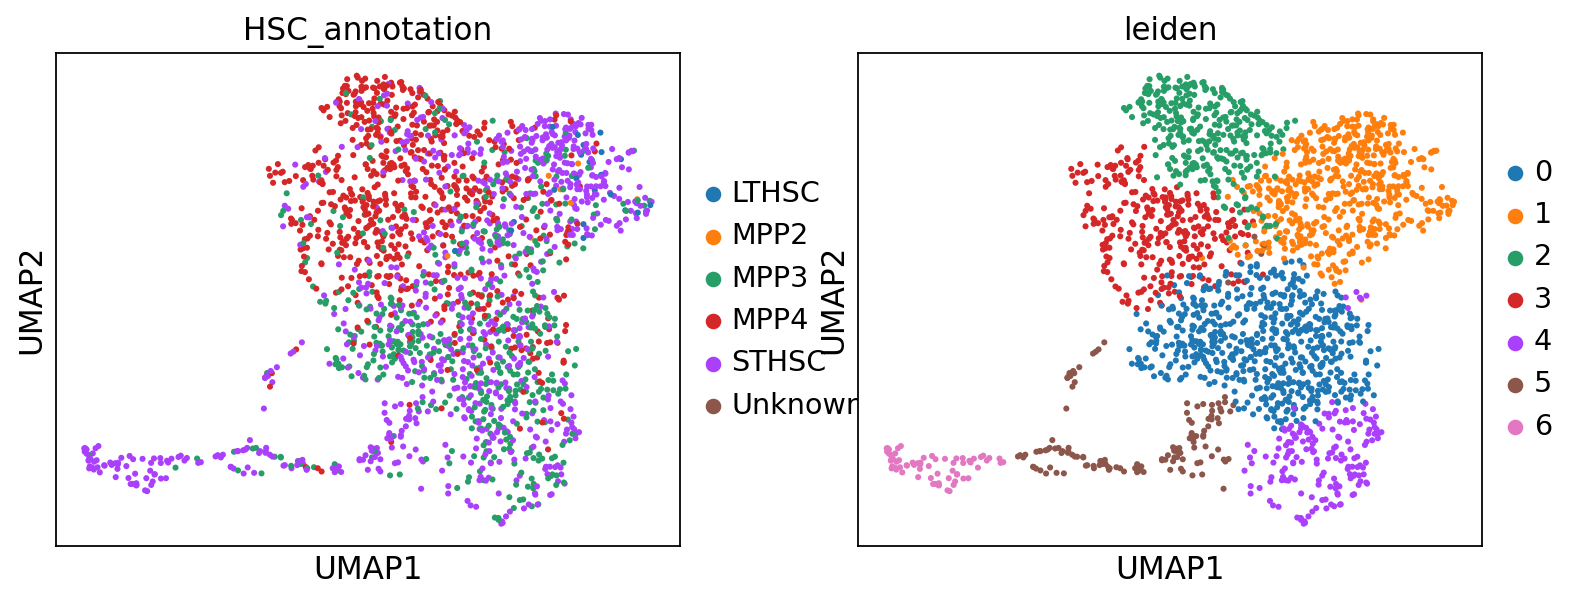

In [117]:
sc.set_figure_params(figsize = (5,4))
sc.pl.umap(hvg_subset_HSC, color=['HSC_annotation', 'leiden'], size = 30
           # ,save = "all_HSC_umap.pdf"
          )

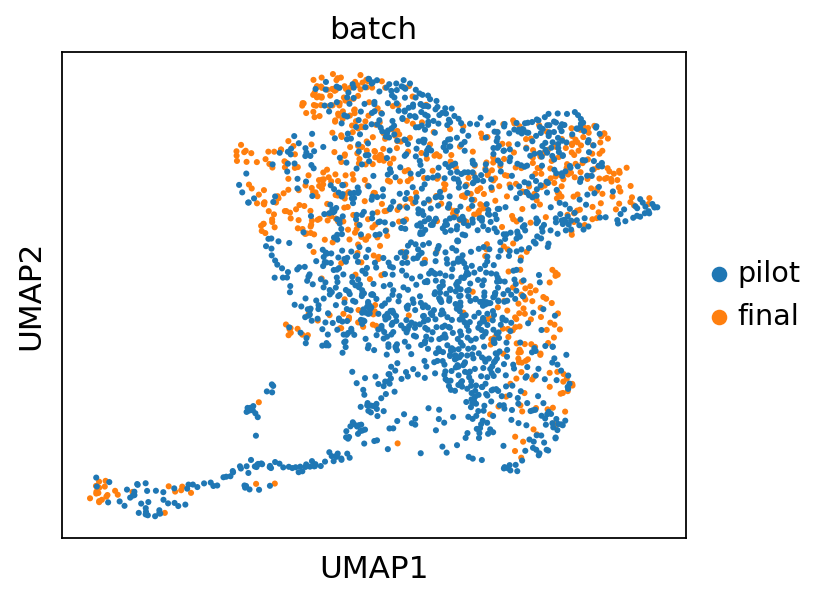

In [9]:
sc.set_figure_params(figsize = (5,4))
sc.pl.umap(hvg_subset_HSC, color='batch', size = 30
           # ,save = "all_HSC_umap.pdf"
          )

In [10]:
sc.pp.normalize_total(hvg_subset_HSC, target_sum=1e6)
sc.pp.log1p(hvg_subset_HSC)

In [11]:
sc.tl.pca(hvg_subset_HSC)
sc.pp.neighbors(hvg_subset_HSC)
sc.tl.umap(hvg_subset_HSC, random_state=1)


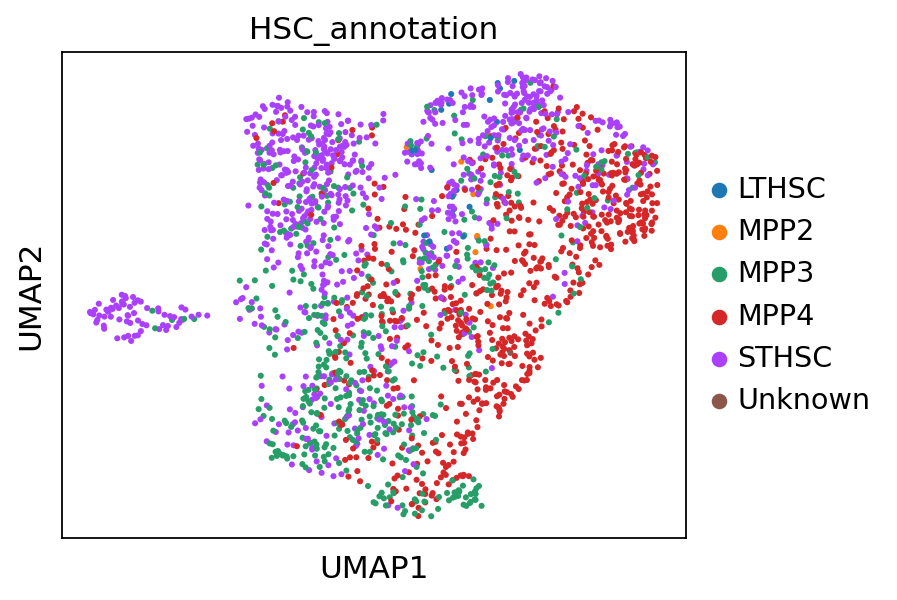

In [12]:
sc.set_figure_params(figsize = (5,4))
sc.pl.umap(hvg_subset_HSC, color='HSC_annotation', size = 30
           # ,save = "all_HSC_umap.pdf"
          )

In [62]:
# hvg_subset_HSC.obsm
# hvg_subset_HSC.obsm["X_mde"] = mde(hvg_subset_HSC.obsm["X_scVI"])

### Heatmap of differentially expressed genes

In [18]:
hvg_subset_HSC = hvg_subset_HSC[hvg_subset_HSC.obs['HSC_annotation'] != "Unknown"]

In [67]:
hvg_subset_HSC.obs["HSC_annotation"].value_counts()

STHSC    868
MPP4     696
MPP3     535
LTHSC     22
MPP2       7
Name: HSC_annotation, dtype: int64

In [185]:
# sc.tl.pca(hvg_subset_HSC, svd_solver='arpack')
# sc.pp.neighbors(hvg_subset_HSC, n_neighbors=10, n_pcs=40)
# sc.tl.umap(hvg_subset_HSC)

In [68]:
# sc.tl.leiden(hvg_subset_HSC)

Trying to set attribute `.obs` of view, copying.


In [70]:
# sc.tl.rank_genes_groups(hvg_subset_HSC, 'leiden', method='wilcoxon', use_raw = False)

In [21]:
sc.pp.normalize_total(hvg_subset_HSC, target_sum=1e6)
sc.pp.log1p(hvg_subset_HSC)

In [78]:
sc.tl.rank_genes_groups(hvg_subset_HSC, 'HSC_annotation', method='wilcoxon', use_raw = False)

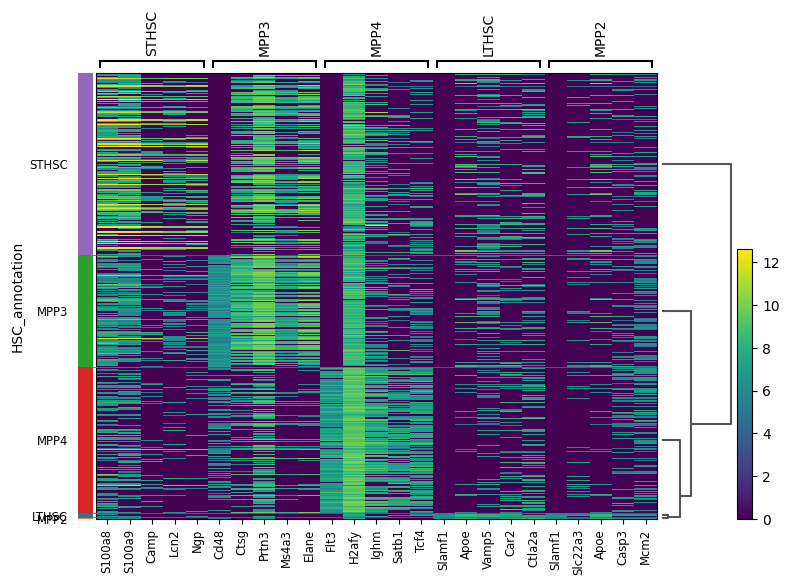

In [79]:
sc.pl.rank_genes_groups_heatmap(hvg_subset_HSC, use_raw = False, n_genes = 5, save = 'HSC_top5_genes_heatmap.pdf')

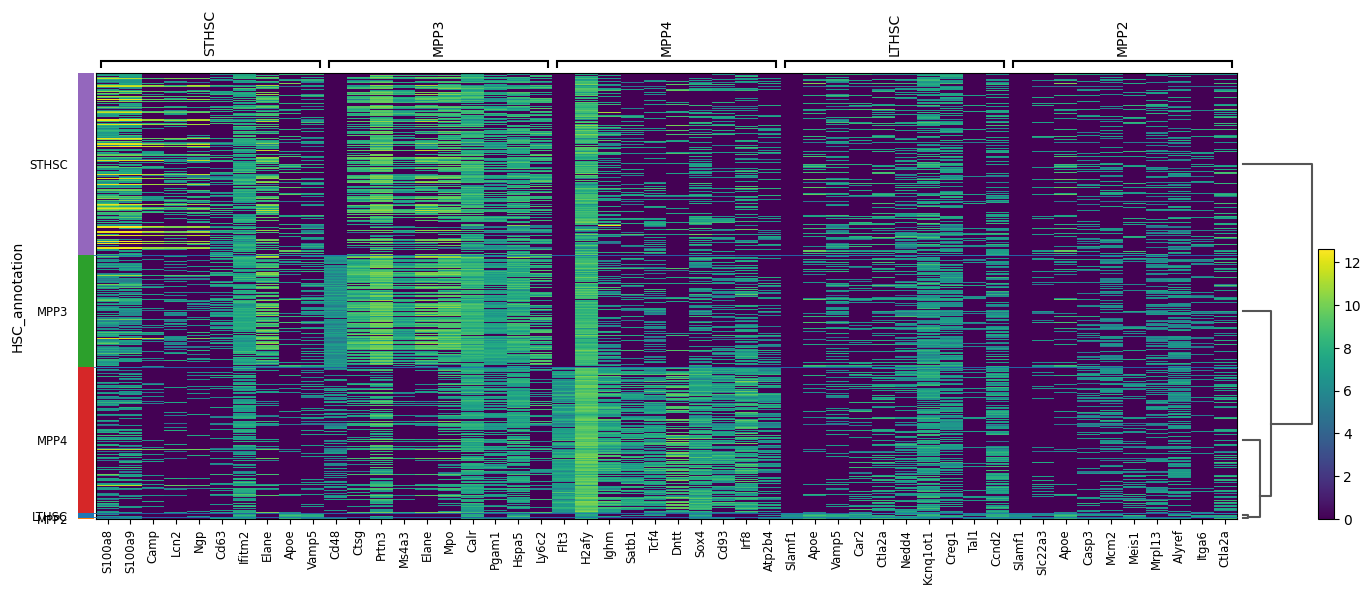

In [80]:
sc.pl.rank_genes_groups_heatmap(hvg_subset_HSC, use_raw = False, save = 'HSC_genes_heatmap.pdf')

### Writing DEG genes to an excel file

In [84]:
write_rank_genes_groups_to_excel(adata = hvg_subset_HSC, excel_path = "HSC_DEGs_scnym.xlsx")

## Clustering HSC population

### Manual annotation by Mariem

In [118]:
HSC_cell_mapping = {"0":"CMP",
               "1": "HSC",
               "2": "CLP",
               "3": "CLP",
               "4": "GMP",
               "5": "Neutro",
               "6": "EoP"}

In [119]:
hvg_subset_HSC.obs["Mariem_annotation"] = hvg_subset_HSC.obs["leiden"].map(HSC_cell_mapping)

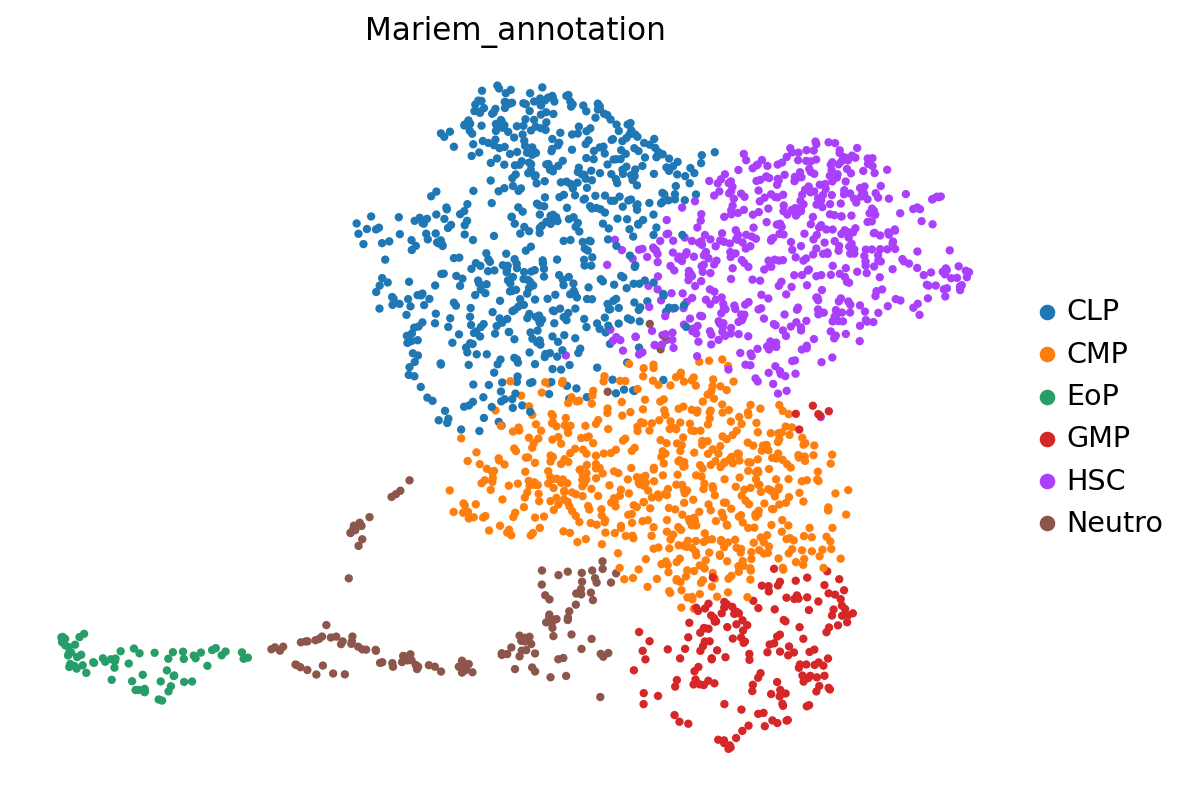

In [120]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset_HSC,
    basis="umap",
    color=['Mariem_annotation'],
    frameon=False,
    ncols=1,
    save = "HSC_leiden_manual_annotation_legend.pdf"
)

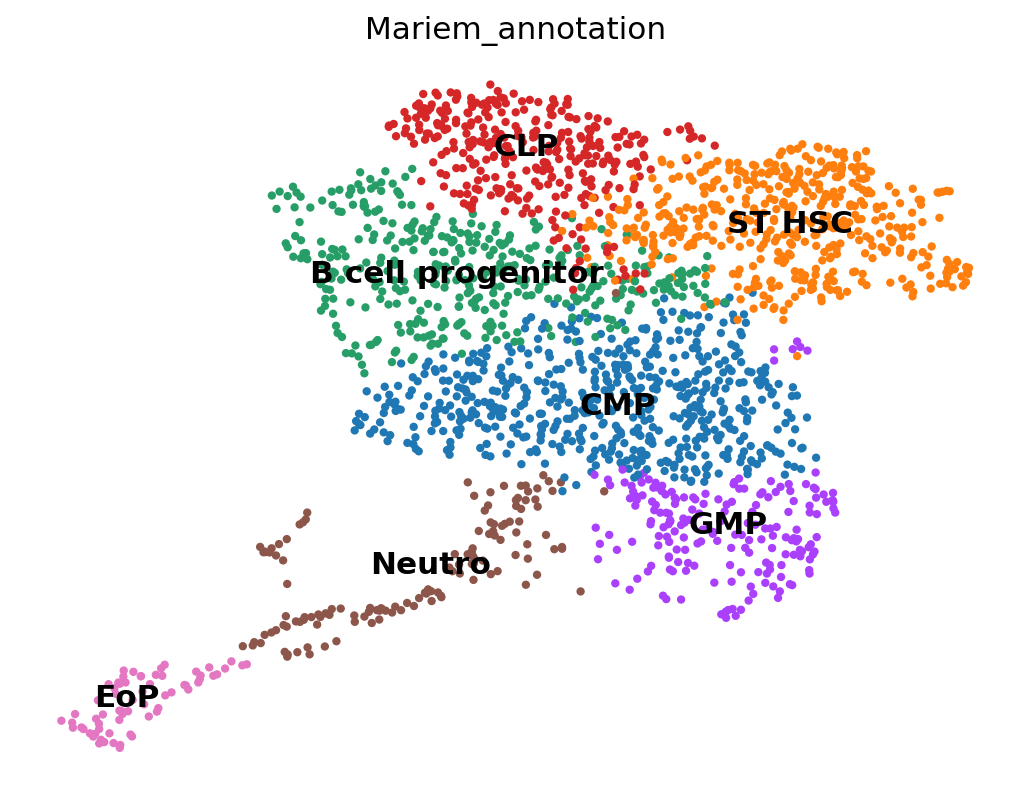

In [48]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset_HSC,
    basis="umap",
    color=['Mariem_annotation'],
    frameon=False,
    ncols=1,
    legend_loc = "on data",
    save = "HSC_leiden_manual_annotation_ondata.pdf"
)

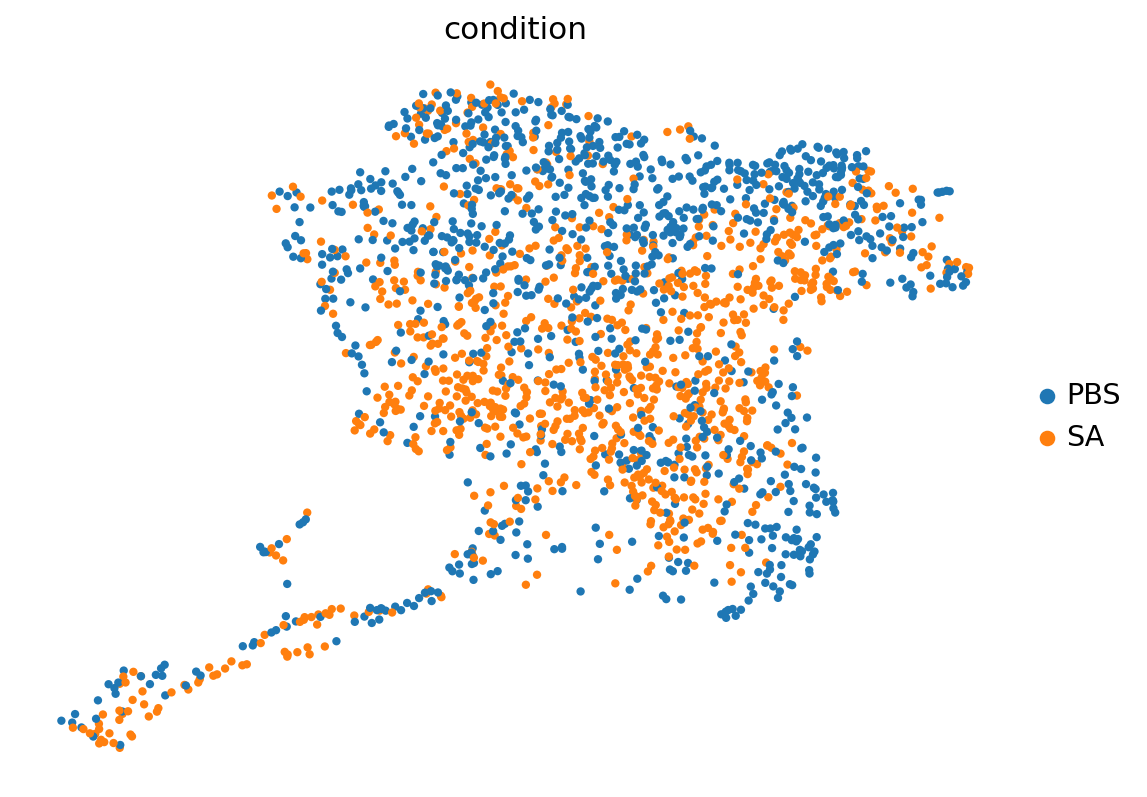

In [116]:
sc.set_figure_params(figsize = (8,6))
sc.pl.embedding(
    hvg_subset_HSC,
    basis="umap",
    color=['condition'],
    frameon=False,
    ncols=1,
    save = "HSC_leiden_SA_vs_PBS.pdf"
)

In [121]:
hvg_subset_HSC.write_loom(filename = "hvg_subset_HSC_MA_annotations.loom")

The loom file will lack these fields:
{'PCs', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_mde', 'X_tsne', 'X_umap', 'X_pca', 'X_scVI'}
Use write_obsm_varm=True to export multi-dimensional annotations


### DEG for MA annotation

In [30]:
hvg_subset_HSC = sc.read_loom(filename = "hvg_subset_HSC_MA_annotations.loom")

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [83]:
hvg_subset_HSC.var

Empty DataFrame
Columns: []
Index: [0610009B22Rik, 0610010K14Rik, 0610038B21Rik, 1010001B22Rik, 1110004F10Rik, 1110006O24Rik, 1110008P14Rik, 1110019D14Rik, 1110020A21Rik, 1110028F11Rik, 1110038B12Rik, 1110065P20Rik, 1190001M18Rik, 1190005I06Rik, 1190007I07Rik, 1300002E11Rik, 1500009L16Rik, 1600010M07Rik, 1700001C19Rik, 1700001L05Rik, 1700001O22Rik, 1700006J14Rik, 1700010I14Rik, 1700010K24Rik, 1700012B09Rik, 1700012D14Rik, 1700020L24Rik, 1700021F05Rik, 1700025G04Rik, 1700027J07Rik, 1700028E10Rik, 1700029J07Rik, 1700037H04Rik, 1700047M11Rik, 1700048O20Rik, 1700055D18Rik, 1700062C10Rik, 1700097N02Rik, 1700113A16Rik, 1700113H08Rik, 1700123M08Rik, 1810009A15Rik, 1810037I17Rik, 1810059H22Rik, 1810073O08Rik, 2010007H06Rik, 2010204K13Rik, 2210016F16Rik, 2310009B15Rik, 2310033P09Rik, 2310034G01Rik, 2310039H08Rik, 2310040G24Rik, 2310047D07Rik, 2310075C17Rik, 2410002F23Rik, 2410003L11Rik, 2410004B18Rik, 2410080I02Rik, 2510009E07Rik, 2610008E11Rik, 2610306M01Rik, 2700038G22Rik, 2700081O15Rik, 2810004N23Rik, 2810405F17Rik, 2810408I11Rik, 2810429I04Rik, 2810454H06Rik, 2810468N07Rik, 2900026A02Rik, 2900041M22Rik, 2900052L18Rik, 2900060N12Rik, 2900079G21Rik, 3110082I17Rik, 3830403N18Rik, 4732465J04Rik, 4732496C06Rik, 4833403J16Rik, 4930405A21Rik, 4930431P03Rik, 4930438A08Rik, 4930445N18Rik, 4930447C04Rik, 4930452B06Rik, 4930455G09Rik, 4930458D05Rik, 4930481A15Rik, 4930503L19Rik, 4930513N10Rik, 4930519L02Rik, 4930548H24Rik, 4930550C14Rik, 4930556M19Rik, 4930562F07Rik, 4930563E22Rik, 4931428F04Rik, 4933406C10Rik, 4933406I18Rik, ...]

[5182 rows x 0 columns]

In [36]:
# hvg_subset_HSC.var.index = hvg_subset_HSC.var['var_names']

In [84]:
sc.pp.normalize_total(hvg_subset_HSC, target_sum=1e6)
sc.pp.log1p(hvg_subset_HSC)

In [87]:
sc.tl.rank_genes_groups(hvg_subset_HSC, 'Mariem_annotation', method='wilcoxon', use_raw = False)
write_rank_genes_groups_to_excel(adata = hvg_subset_HSC, excel_path = "HSC_DEGs_leiden_MA_annotation.xlsx")

### DEG for leiden

In [92]:
sc.tl.rank_genes_groups(hvg_subset_HSC, 'leiden', method='wilcoxon', use_raw = False)
write_rank_genes_groups_to_excel(adata = hvg_subset_HSC, excel_path = "HSC_DEGs_leiden.xlsx")

## Mature cell populations

In [31]:
SA_mature = SA_exps[ SA_exps.obs["scNym_condensed"] != "hematopoietic precursor cell" ]

In [31]:
SA_mature.obs_names

Index(['AAACCCATCGTGCACG-1-0', 'AAACGAAGTCGGTAAG-1-0', 'AAACGCTCATGAGGGT-1-0',
       'AAACGCTTCTCCTGTG-1-0', 'AAAGAACAGGATATAC-1-0', 'AAAGAACCACTACACA-1-0',
       'AAAGAACCAGCCGTCA-1-0', 'AAAGGATGTAGCTAAA-1-0', 'AAAGGATGTGGGATTG-1-0',
       'AAAGGATTCTGACGCG-1-0',
       ...
       'TTTGGTTTCTAACGCA-1-4', 'TTTGGTTTCTAGTGAC-1-4', 'TTTGGTTTCTTACCAT-1-4',
       'TTTGTTGAGCACGATG-1-4', 'TTTGTTGGTCCACTCT-1-4', 'TTTGTTGGTCCACTTC-1-4',
       'TTTGTTGGTCCTGGTG-1-4', 'TTTGTTGGTTGTAAAG-1-4', 'TTTGTTGTCGTGGAAG-1-4',
       'TTTGTTGTCTGCTAGA-1-4'],
      dtype='object', length=8238)

In [32]:
ann_counts = Counter([x[:-2] for x in SA_mature.obs_names])
unique_names = [x for x in SA_mature.obs_names if ann_counts[x[:-2]] == 1]
SA_mature = SA_mature[unique_names]
SA_mature.obs_names = [x[:-2] for x in SA_mature.obs_names]
common_cells = SA_mature.obs_names.intersection(hvg_subset.obs_names)
hvg_subset_mature = hvg_subset[common_cells]
SA_mature = SA_mature[common_cells]

In [33]:
SA_mature.obs["scNym_condensed"]

AAACGCTTCTCCTGTG-1    granulocyte
AAAGAACCACTACACA-1         B cell
AAAGAACCAGCCGTCA-1         B cell
AAAGGATGTAGCTAAA-1       basophil
AACAAAGGTGTTGCCG-1         T cell
                         ...     
TTTGGAGCACGGTGCT-1       monocyte
TTTGGTTCAGAGACTG-1     macrophage
TTTGTTGAGCACGATG-1     macrophage
TTTGTTGGTCCACTCT-1         B cell
TTTGTTGGTCCTGGTG-1     macrophage
Name: scNym_condensed, Length: 3385, dtype: object

In [34]:
hvg_subset_mature.obs["mature_annotation"] = SA_mature.obs["scNym_condensed"]

Trying to set attribute `.obs` of view, copying.


In [22]:
sc.tl.pca(hvg_subset_mature)
sc.pp.neighbors(hvg_subset_mature)
sc.tl.umap(hvg_subset_mature)

In [27]:
# sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
sc.pl.embedding(
    hvg_subset_mature,
    basis="umap",
    color=['mature_annotation', 'batch'],
    frameon=False,
    ncols=1
)

ZeroDivisionError: division by zero

<Figure size 727.8x960 with 0 Axes>

In [22]:
sc.tl.leiden(hvg_subset_mature, n_iterations=-1)

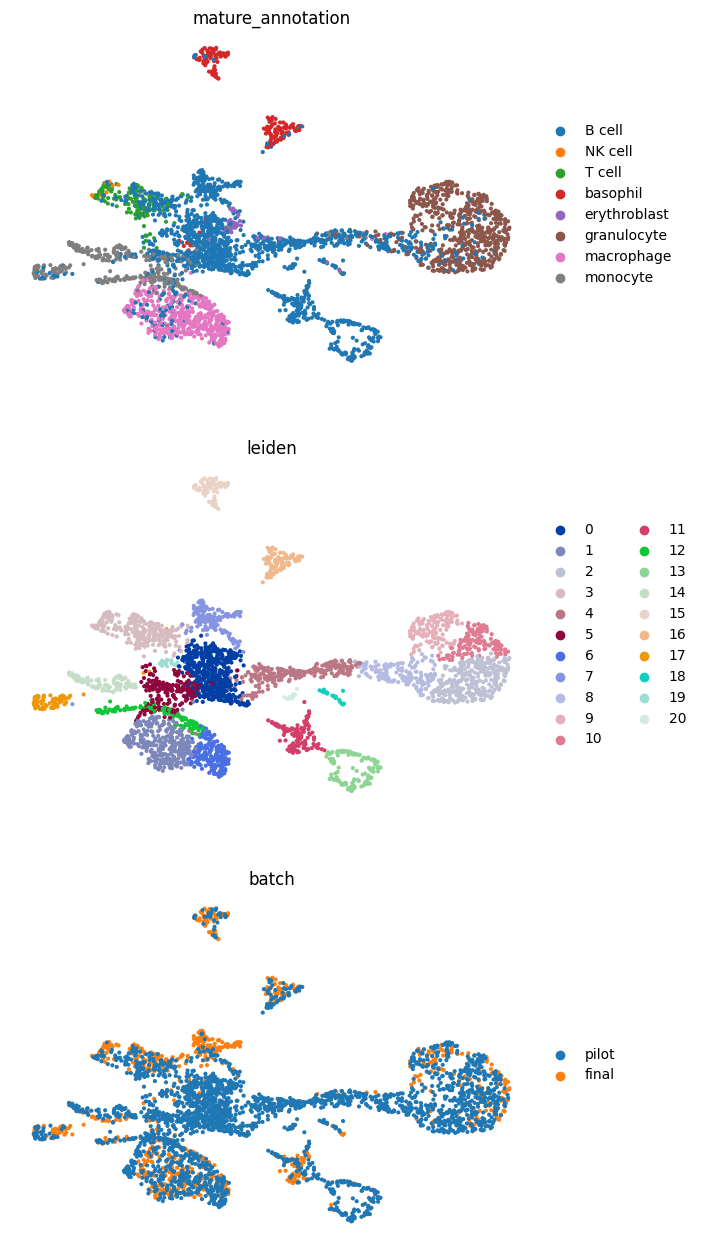

In [24]:
# sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
sc.pl.embedding(
    hvg_subset_mature,
    basis="umap",
    color=['mature_annotation', 'leiden', 'batch'],
    frameon=False,
    ncols=1
)

### Writing mature populations

In [7]:
hvg_subset_mature.obs.to_pickle("hvg_mature_annotation.plk")
hvg_subset_mature.obs = hvg_subset_mature.obs[["mature_annotation"]]
hvg_subset_mature.write(filename = "hvg_mature_annotation.h5ad")

/users/anna.hakobyan/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'mature_annotation' as categorical


### Reading mature populations

In [88]:
hvg_subset_mature = sc.read_h5ad(filename = "hvg_mature_annotation.h5ad")
obs_plk = pd.read_pickle("hvg_mature_annotation.plk")
hvg_subset_mature.obs = obs_plk

In [89]:
sc.pp.normalize_total(hvg_subset_mature, target_sum=1e6)
sc.pp.log1p(hvg_subset_mature)

In [7]:
# hvg_subset_mature.write_loom(filename = "hvg_subset_mature.loom")

/users/anna.hakobyan/.conda/envs/scpython/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [90]:
hvg_subset_mature.X.toarray().max(axis = 0).max()

13.658878

In [274]:
random.seed(1234)
sc.tl.pca(hvg_subset_mature, random_state = 112345)
sc.pp.neighbors(hvg_subset_mature, random_state=5231)
sc.tl.umap(hvg_subset_mature, random_state=1236789)

In [301]:
sc.tl.leiden(hvg_subset_mature, resolution = 0.95, n_iterations=-1, random_state= 133366779)


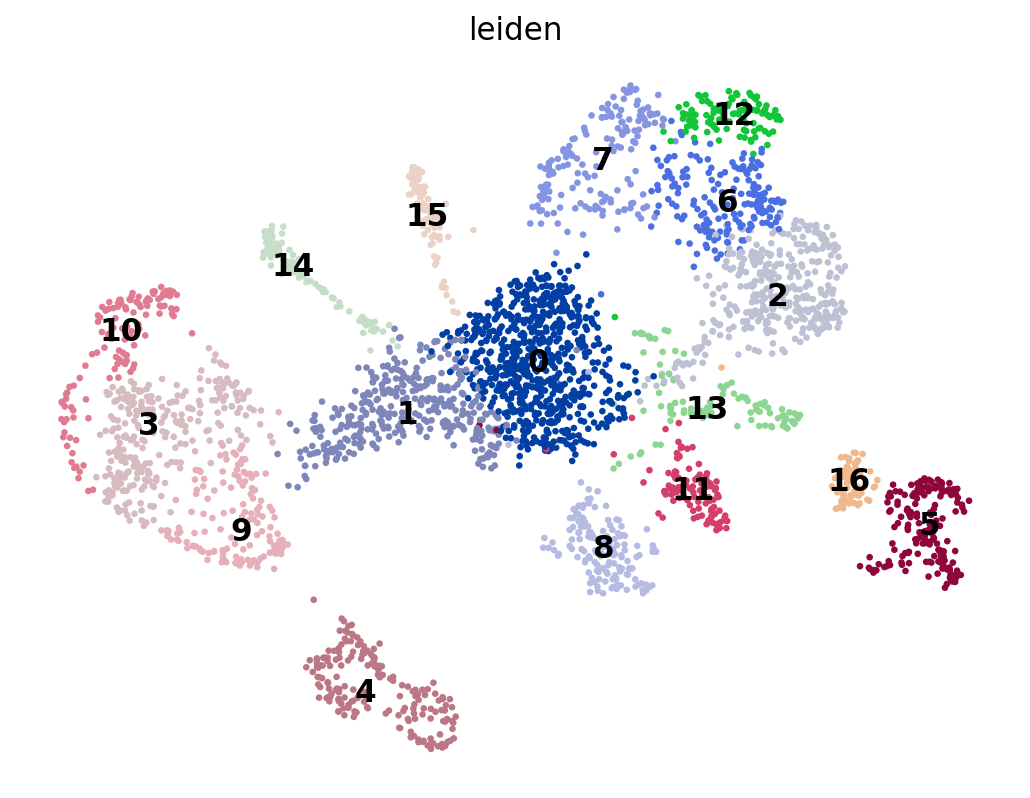

In [302]:
# sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
sc.pl.embedding(
    hvg_subset_mature,
    basis="umap",
    color=['leiden'],
    frameon=False,
    ncols=1,
    legend_loc = "on data"
)

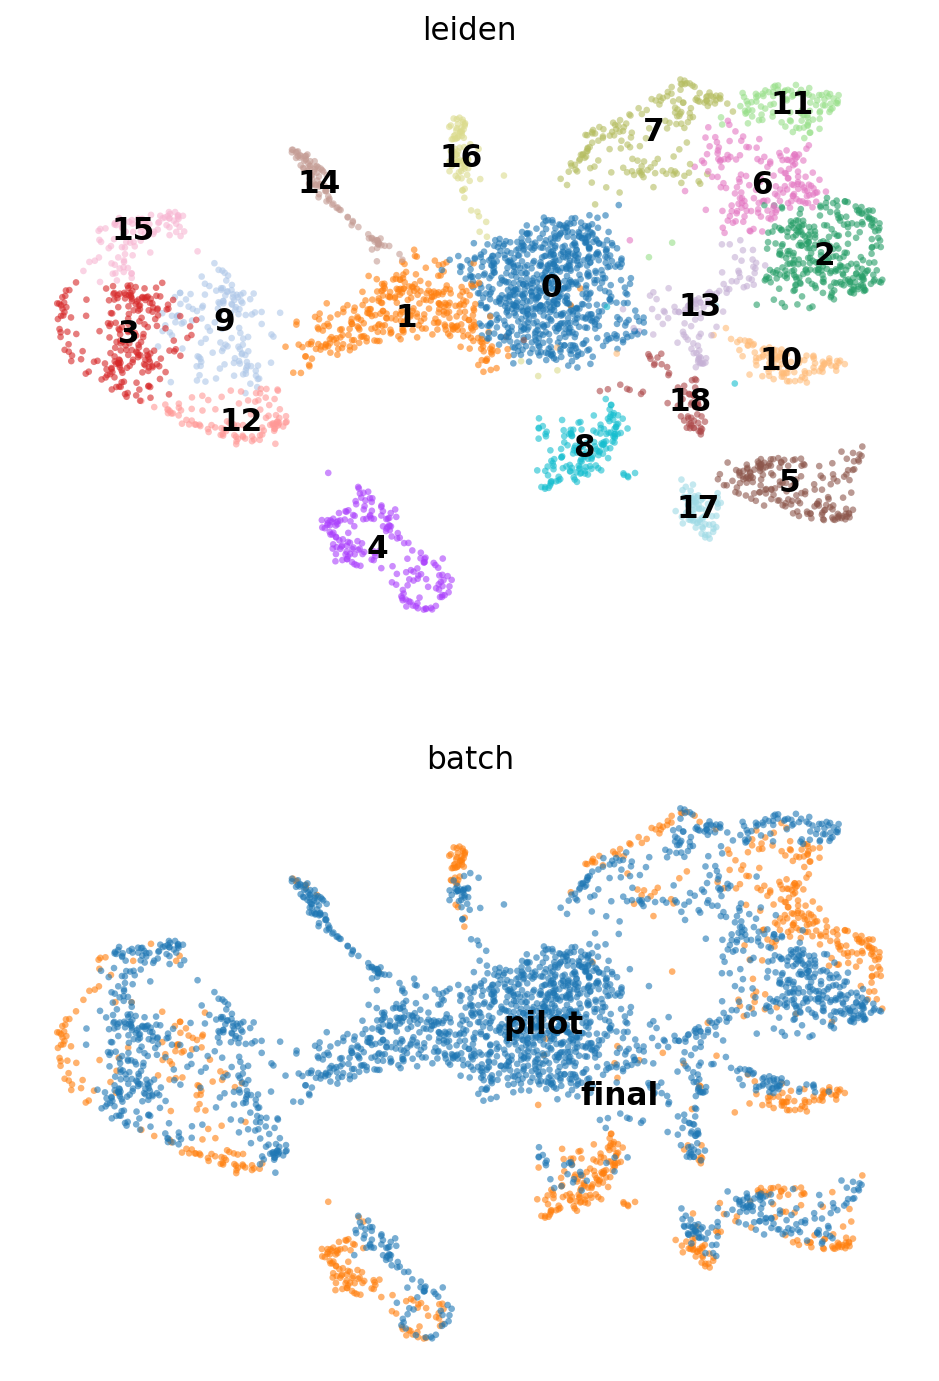

In [100]:
sc.set_figure_params(figsize = (7,5))

sc.pl.embedding(
    hvg_subset_mature,
    basis="umap",
    alpha = 0.6,
    color=['leiden', 'batch'],
    frameon=False,
    legend_loc='on data',
    ncols=1
)

In [39]:
hvg_subset_mature.obs["mature_annotation"].value_counts()

B cell          1609
granulocyte      595
macrophage       480
monocyte         339
basophil         171
T cell           124
erythroblast      57
NK cell           10
Name: mature_annotation, dtype: int64

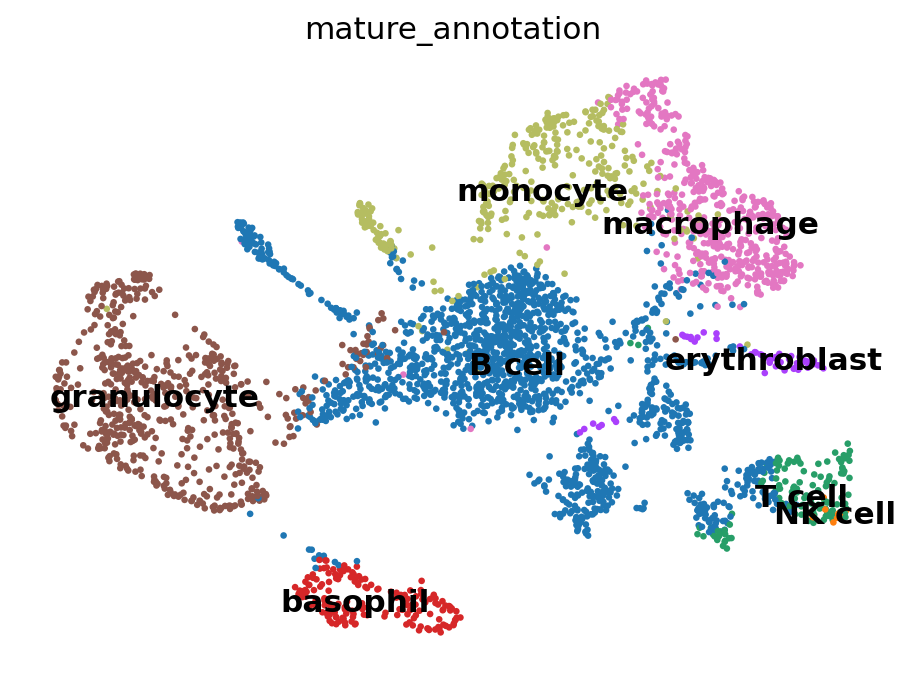

In [39]:
sc.pl.embedding(
    hvg_subset_mature,
    basis="umap",
    color=['mature_annotation'],
    frameon=False,
    ncols=1,
    legend_loc='on data',
    save = "scNym_umap_mature_annotations.pdf"
)

In [164]:
sc.tl.rank_genes_groups(hvg_subset_mature, 'mature_annotation', method='wilcoxon', use_raw = False)
write_rank_genes_groups_to_excel(adata = hvg_subset_mature, excel_path = "mature_DEGs_scnym.xlsx")

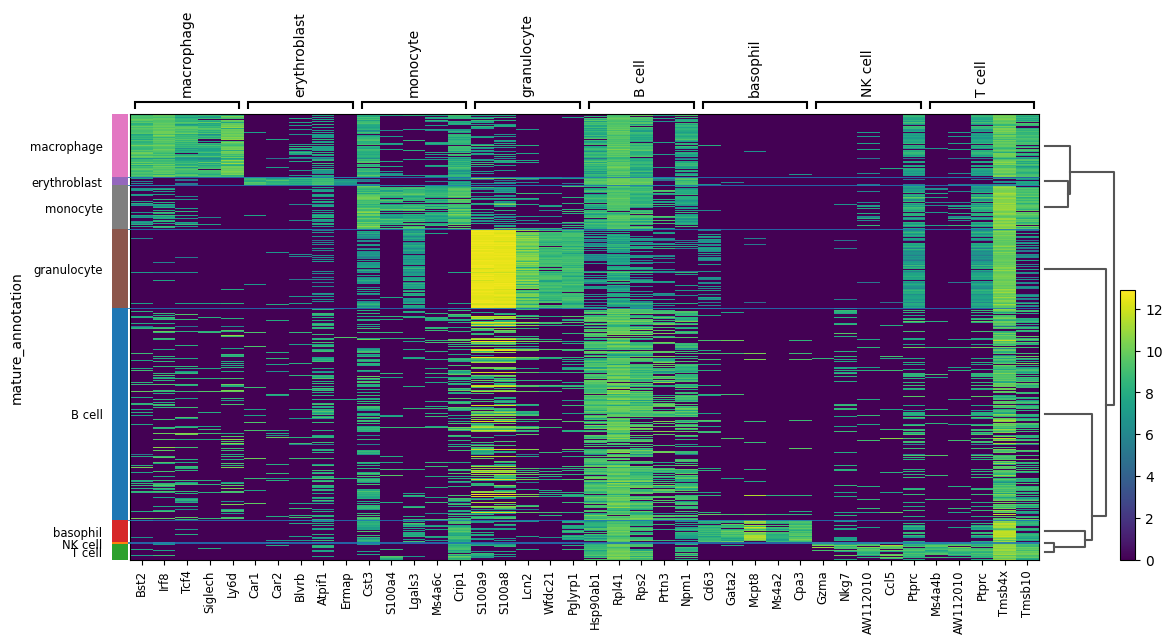

In [165]:
sc.pl.rank_genes_groups_heatmap(hvg_subset_mature, n_genes = 5, use_raw = False, save = "scNym_annotation_mature.pdf")

### Mature cell populations with leiden

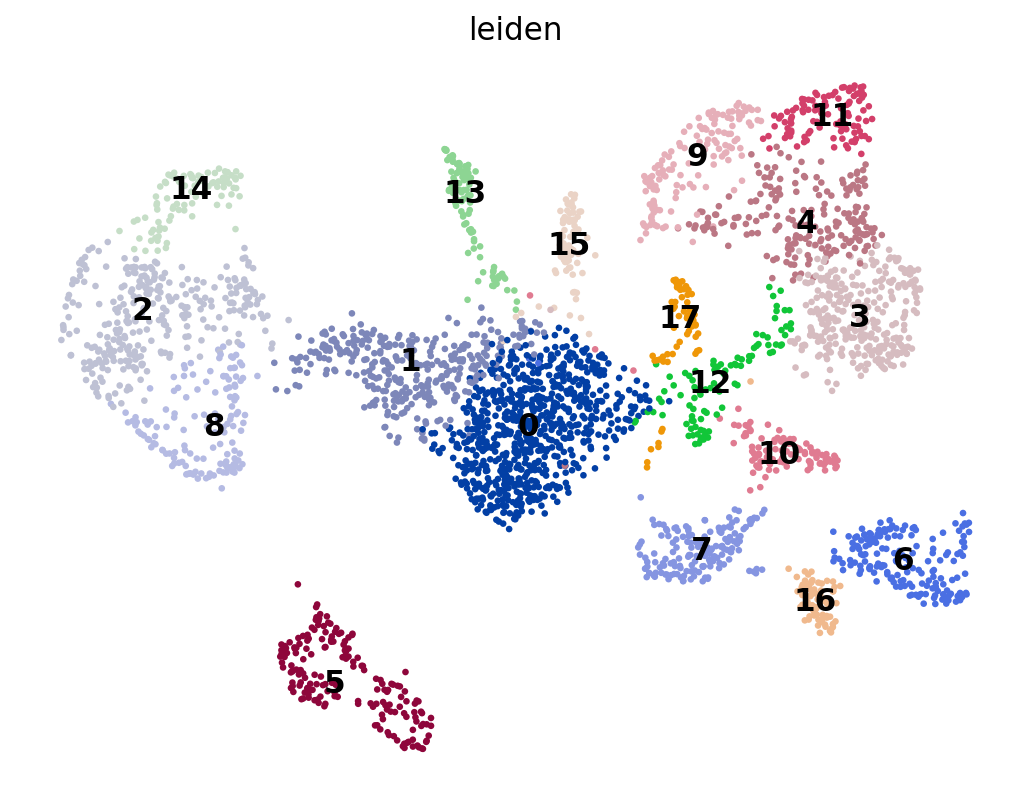

In [144]:
# sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
sc.pl.embedding(
    hvg_subset_mature,
    basis="umap",
    color=['leiden'],
    frameon=False,
    ncols=1,
    legend_loc = "on data",
    save = "mature_leiden_umap_on_data.pdf"
)

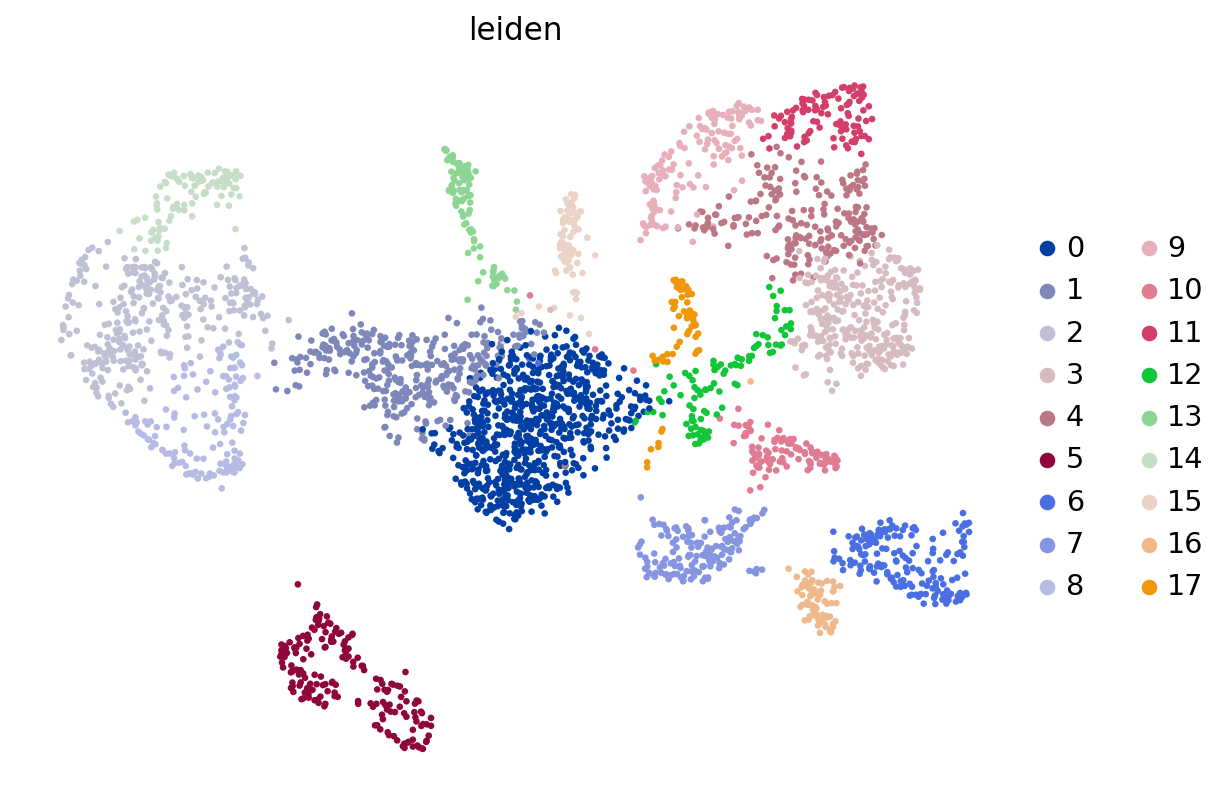

In [145]:
# sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
sc.pl.embedding(
    hvg_subset_mature,
    basis="umap",
    color=['leiden'],
    frameon=False,
    ncols=1,
    save = "mature_leiden_umap.pdf"
)

In [45]:
hvg_subset_mature.obs['leiden'][1:5]

AAAGAACCACTACACA-1     8
AAAGAACCAGCCGTCA-1    10
AAAGGATGTAGCTAAA-1     4
AACAAAGGTGTTGCCG-1     6
Name: leiden, dtype: category
Categories (18, object): [0, 1, 2, 3, ..., 14, 15, 16, 17]

In [168]:
sc.tl.rank_genes_groups(hvg_subset_mature, 'leiden', method='wilcoxon', use_raw = False)
write_rank_genes_groups_to_excel(adata = hvg_subset_mature, excel_path = "mature_DEGs_leiden.xlsx")

### Manual annotation by Mariem

In [122]:
mature_cell_mapping = {"0":"Other",
               "1": "Neutrophil 1",
               "2": "Neutrophil 2",
               "3": "Macrophages",
               "4": "Baso/Mast",
               "5": "Dendritic",
               "6": "T",
               "7": "Monocyte 1",
               "8": "B early",
               "9": "Eosinophil",
               "10": "B mature",
               "11": "Progenitor",
               "12": "B mature",
               "13": "B mature",
               "14": "Monocyte 2",
               "15": "ILC",
               "16": "Neutrophil 3",
               "17": "Erythroblast"}

#### Annotation for Supp. Table 1

In [304]:
mature_cell_mapping = {"0":"Other",
               "1": "Early granulocyte",
               "2": "Macrophages",
               "3": "Neutrophil",
               "4": "Baso/Mast",
               "5": "T",
               "6": "Dendritic",
               "7": "Monocyte 1",
               "8": "B early",
               "9": "Neutrophil",
               "10": "Eosinophil",
               "11": "B mature",
               "12": "Monocyte 1",
               "13": "Erythroblast",
               "14": "B mature",
               "15": "Monocyte 2",
               "16": "ILC"}

In [305]:
hvg_subset_mature.obs["Mariem_annotation"] = hvg_subset_mature.obs["leiden"].map(mature_cell_mapping)

In [106]:
sc.tl.rank_genes_groups(hvg_subset_mature, 'Mariem_annotation', method='wilcoxon', use_raw = False)
write_rank_genes_groups_to_excel(adata = hvg_subset_mature, excel_path = "mature_DEGs_leiden_MA_annotation.xlsx")

... storing 'Mariem_annotation' as categorical


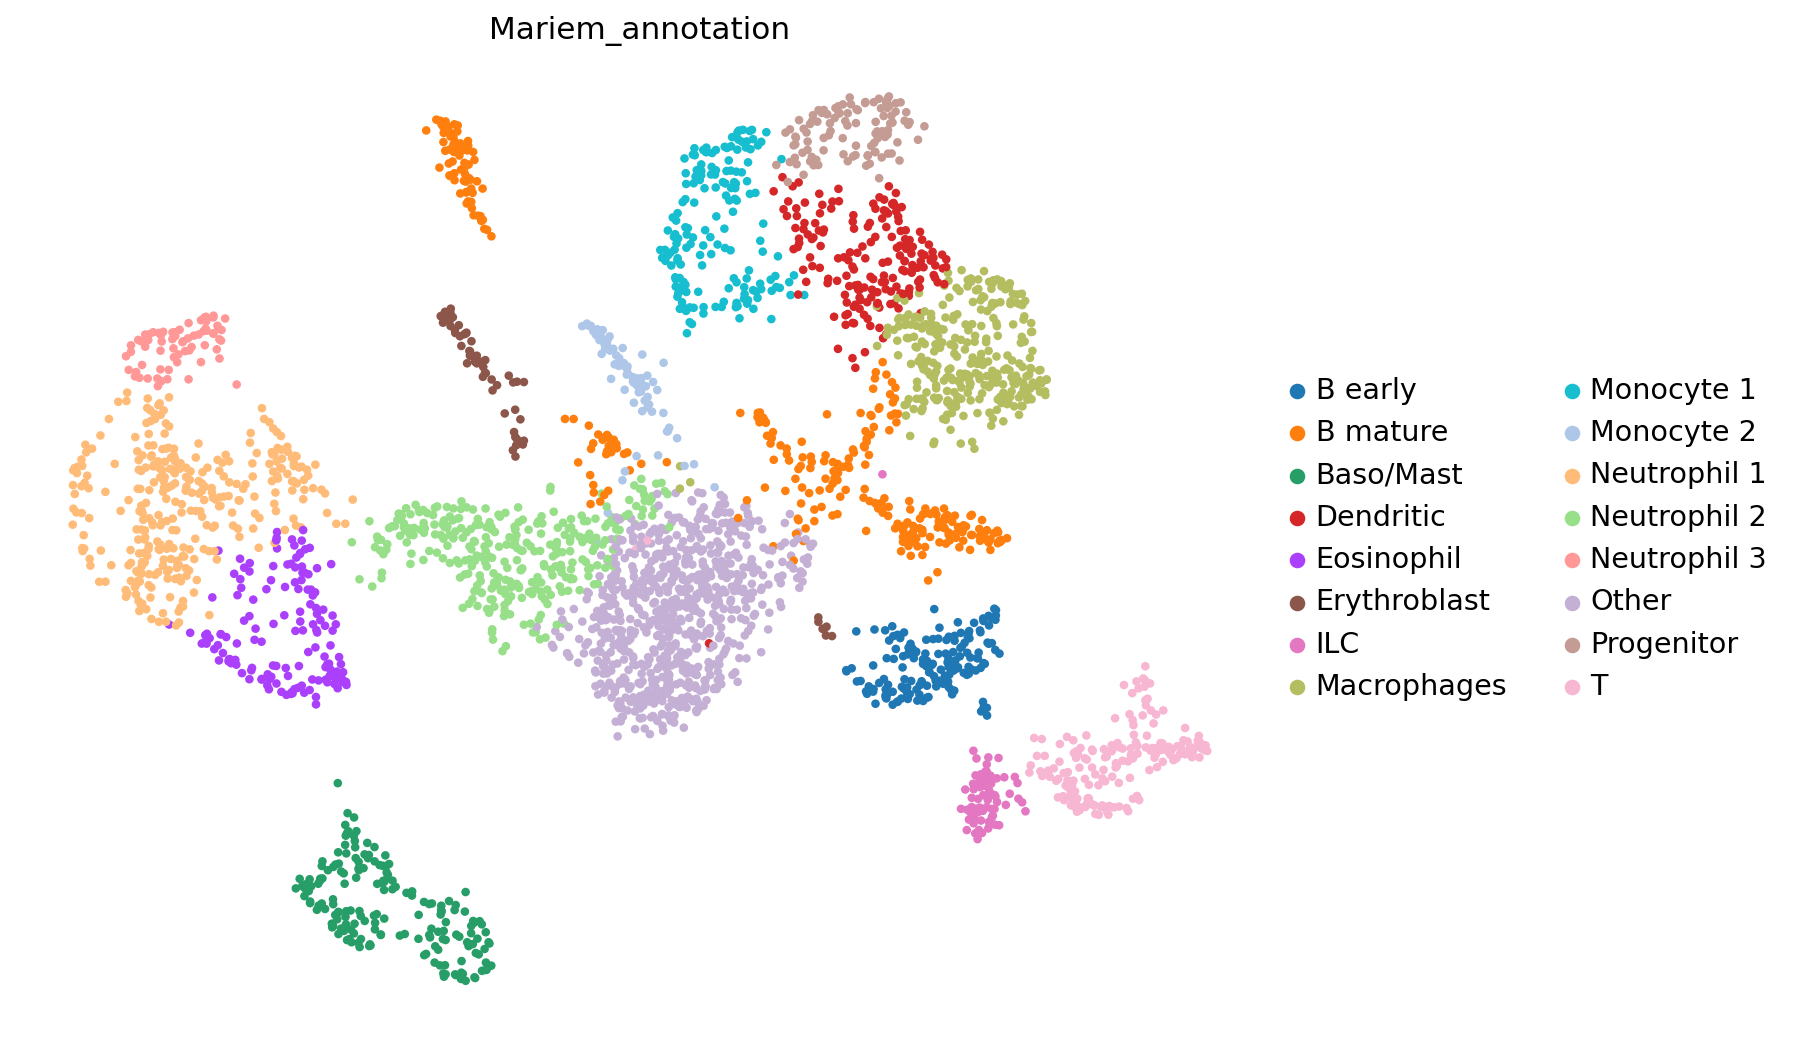

In [42]:
sc.set_figure_params(figsize = (10,8))
sc.pl.embedding(
    hvg_subset_mature,
    size = 60,
    basis="umap",
    color=['Mariem_annotation'],
    frameon=False,
    ncols=1,
    save = "mature_leiden_manual_annotation_legend.pdf"
)

In [ ]:
sc.set_figure_params(figsize = (10,8))
sc.pl.embedding(
    hvg_subset_mature,
    size = 60,
    basis="umap",
    color=['Mariem_annotation'],
    frameon=False,
    ncols=1,
    legend_loc = "on data",
    save = "mature_leiden_manual_annotation.pdf"
)

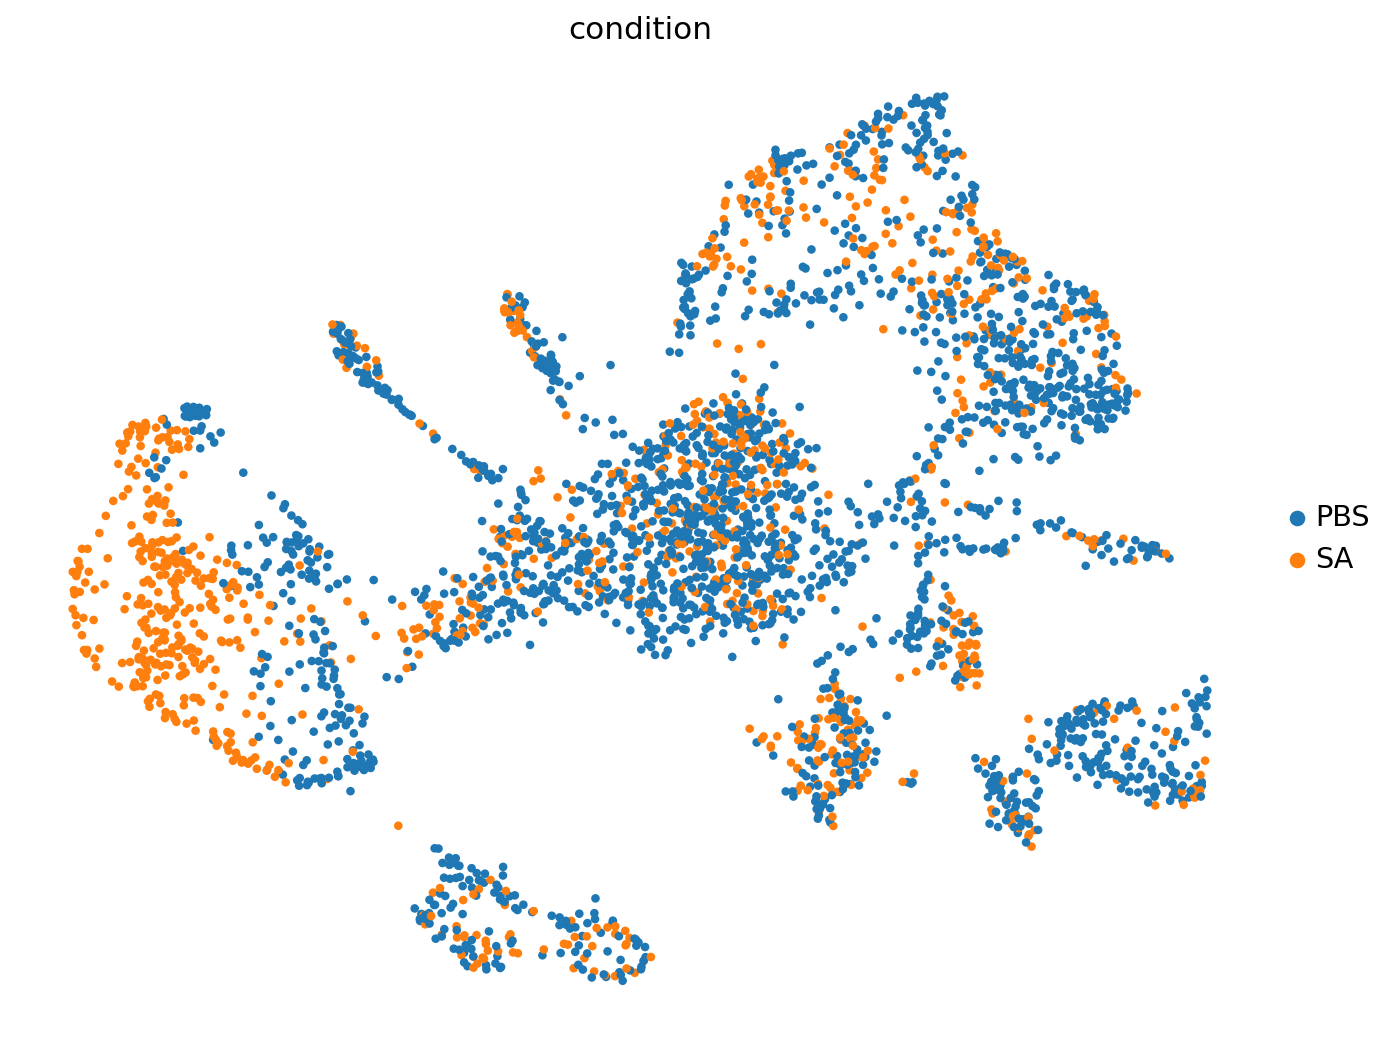

In [112]:
sc.set_figure_params(figsize = (10,8))
sc.pl.embedding(
    hvg_subset_mature,
    size = 60,
    basis="umap",
    color=['condition'],
    frameon=False,
    ncols=1,
    save = "mature_leiden_SA_vs_PBS.pdf"
)

In [306]:
hvg_subset_mature.write_loom(filename = "hvg_subset_mature_MA_annotations.loom")

The loom file will lack these fields:
{'PCs', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_mde', 'X_tsne', 'X_umap', 'X_pca', 'X_scVI'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [307]:
hvg_subset_mature.obs["Mariem_annotation"].value_counts()

Other                708
Neutrophil           418
Early granulocyte    364
Macrophages          356
Monocyte 1           269
B mature             202
Baso/Mast            182
T                    176
Dendritic            172
B early              158
Eosinophil           124
Erythroblast         100
Monocyte 2            82
ILC                   74
Name: Mariem_annotation, dtype: int64

In [308]:
hvg_subset_mature.obs["leiden"].value_counts()

0     708
1     364
2     356
3     273
4     182
5     176
6     172
7     165
8     158
9     145
10    124
11    106
12    104
13    100
14     96
15     82
16     74
Name: leiden, dtype: int64